## Importing Necessary Packages

In [1165]:
import config
from bs4 import BeautifulSoup
import requests
import mysql.connector 
from mysql.connector import errorcode
import json
import datetime
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
import os
import time
import random
import nltk

from os import system
from math import floor
from copy import deepcopy
import itertools

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn import tree 
from sklearn.preprocessing import OneHotEncoder
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pandas as pd 
import numpy as np 
from sklearn.metrics import accuracy_score, f1_score, precision_score,\
                            recall_score, roc_auc_score, mean_squared_error,\
                            classification_report, confusion_matrix, roc_curve, auc



from sklearn.base import clone
from sklearn.utils import resample
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import xgboost as xgb


from sklearn.externals.six import StringIO 
from IPython.display import Image  
import logging
import pydotplus

## Obtaining the Data & Storing it

In order to obtain the necessary data, I needed to choose a website that had enough information about the wine to properly classify it without relying on additional sources. Given the variability in wine names and the huge variety of wines on the market, there was no guarantee that I could find additional information about a wine on a different  website.

Wine.com is the website I decided to scrape, given the largest selection of wines and the most comprehensive number of data points about each wine (excluding any specifications such as pH and sugar content, which are often only available in pdf-form technical sheets accessible from each vinyard's website). 

Features about each wine included:

#### Non-Categorical Predictor Features
- Vintage (year wine was produced)
- Country of Origin
- Region of Origin (if available)
- Wine type (e.g. Chardonnay, Pinot Noir, etc.)
- Category (e.g. red wine, white wine, etc.)
- Alcohol Content
- Price
- User Rating
- Number of user reviews (as a proxy of popularity)
- Winery that produced the wine
- Producer description of the wine, including flavors and notes

#### Categorical (yes or no) Predictor Features
- Screw cap or not
- Boutique wine or not (low quantity)
- Advertised by Wine.com as a "Great Gift" wine or not
- Green wine or not (enviornmentally friendly)
- Collectible wine or not

#### Trying to Predict
- Whether the wine is a "critically acclaimed" wine, which is defined as the wine being rated by a well-known wine-rating publication and captured on Wine.com's website

In [379]:
# Creating Selenium driver to navigate to the Wine.com website
driver = webdriver.Chrome()
driver.get('https://www.wine.com')
# close any promotional banners
promotion = driver.find_element_by_class_name('promoBarModal_cancel')
promotion.click()

In [587]:
# Capture wine varieties
menu = driver.find_element_by_class_name('mainNavBtn')
menu.click()
menu_items = driver.find_elements_by_class_name('mainNavList_itemLink ')
len(menu_items)

MaxRetryError: HTTPConnectionPool(host='127.0.0.1', port=65460): Max retries exceeded with url: /session/38017633691af4f8738a104cbe7ecab8/element (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x1a255bfb00>: Failed to establish a new connection: [Errno 61] Connection refused'))

In [ ]:
for e in menu_items: 
    print(e.text)

In [ ]:
print(menu_items[1].text)
menu_items[1].click()

In [577]:
wine_urls = driver.find_elements_by_class_name('prodItemInfo_link')
urls = []
for url in wine_urls:
    urls.append(url.get_attribute('href'))
urls_df = pd.DataFrame(urls)
urls_df.columns = ['url_links']
urls_df.to_csv('bordeaux-white-blends_urls')

In [585]:
len(wine_urls)

50

In [1097]:
def get_urls():
    cnx = mysql.connector.connect(
    host = config.host,
    user = config.user,
    password = config.passwd,
    database = config.database)
    cursor = cnx.cursor()
    cursor.execute("""SELECT url FROM details_old;)""")
    list_of_urls = cursor.fetchall()
    cursor.close()
    return list_of_urls

In [1099]:
all_urls = get_urls()

In [1103]:
driver = webdriver.Chrome()

In [1165]:
all_urls_list = [url[0] for url in all_urls]

In [ ]:
for idx, url in enumerate(all_urls_list[1700:1800]):
    print(f"Accessing url #{idx}, {url}")
    wine_dict = scrape_wine_details(url)
    print(f"obtained wine dict for {wine_dict['wine_name']}")
    wine_details, critic_details = format_for_db(url, wine_dict)
    print(f"formated wine and critic info")
    upload_to_db_wines(wine_details)
    print("updated wine details to db")
    upload_to_db_critics(critic_details)
    print("updated critic details in db")

Accessing url #0, https://www.wine.com/product/wente-riva-ranch-chardonnay-2017/521694
obtained wine dict for Wente Riva Ranch Chardonnay 2017
formated wine and critic info
updated wine details to db
updated critic details in db
Accessing url #1, https://www.wine.com/product/de-wetshof-bon-vallon-chardonnay-2013/131531
obtained wine dict for De Wetshof Bon Vallon Chardonnay 2013
formated wine and critic info
updated wine details to db
updated critic details in db
Accessing url #2, https://www.wine.com/product/gnarly-head-chardonnay-2017/514397
obtained wine dict for Gnarly Head Chardonnay 2017
formated wine and critic info
updated wine details to db
updated critic details in db
Accessing url #3, https://www.wine.com/product/concha-y-toro-casillero-del-diablo-chardonnay-2018/521213
obtained wine dict for Concha y Toro Casillero Del Diablo Chardonnay 2018
formated wine and critic info
updated wine details to db
updated critic details in db
Accessing url #4, https://www.wine.com/product/j

obtained wine dict for Miner Family Wild Yeast Chardonnay 2010
formated wine and critic info
updated wine details to db
updated critic details in db
Accessing url #35, https://www.wine.com/product/chateau-st-jean-creamy-chardonnay-2016/355463
obtained wine dict for Chateau St. Jean Creamy Chardonnay 2016
formated wine and critic info
updated wine details to db
updated critic details in db
Accessing url #36, https://www.wine.com/product/talbott-logan-chardonnay-2014/144312
obtained wine dict for Talbott Logan Chardonnay 2014
formated wine and critic info
updated wine details to db
updated critic details in db
Accessing url #37, https://www.wine.com/product/the-dreaming-tree-chardonnay-2015/173021
obtained wine dict for The Dreaming Tree Chardonnay 2015
formated wine and critic info
updated wine details to db
updated critic details in db
Accessing url #38, https://www.wine.com/product/chalk-hill-estate-chardonnay-2016/519824
obtained wine dict for Chalk Hill Estate Chardonnay 2016
format

updated wine details to db
updated critic details in db
Accessing url #69, https://www.wine.com/product/newton-red-label-chardonnay-2017/524705
obtained wine dict for Newton Red Label Chardonnay 2017
formated wine and critic info
updated wine details to db
updated critic details in db
Accessing url #70, https://www.wine.com/product/walt-la-brisa-chardonnay-2011/126165
obtained wine dict for Walt La Brisa Chardonnay 2011
formated wine and critic info
updated wine details to db
updated critic details in db
Accessing url #71, https://www.wine.com/product/franciscan-estate-chardonnay-2016/430655
obtained wine dict for Franciscan Estate Chardonnay 2016
formated wine and critic info
updated wine details to db
updated critic details in db
Accessing url #72, https://www.wine.com/product/fogdog-chardonnay-2011/131180
obtained wine dict for Fogdog Chardonnay 2011
formated wine and critic info
updated wine details to db
updated critic details in db
Accessing url #73, https://www.wine.com/product/

## Exploratory Data Analysis (EDA) of Wine Data

In [1375]:
df = get_complete_wine_data()

In [1376]:
df.shape

(4366, 22)

In [1377]:
df.head()

,url,name,vintage,country,region,type,category,alcohol,base_price,current_price,discount,size,user_rating,num_reviews,winery,notes,screw_cap,boutique,great_gift,green_wine,collectible,AVG(c.critic_rating)
0,https://www.wine.com/product/1000-stories-bour...,1000 Stories Bourbon Barrel Aged Prospectors' ...,2017,from California,from California,Cabernet Sauvignon,Red Wine,14.9,19.99,19.99,0.0,750ML,4.4,11,1000 Stories,"In the second half of the 19th Century, explor...",0,0,0,1,0,None
1,https://www.wine.com/product/1000-stories-bour...,1000 Stories Bourbon Barrel Aged Zinfandel 2016,2016,from California,from California,Zinfandel,Red Wine,15.6,21.99,21.99,0.0,750ML,4.0,78,1000 Stories,"1,000 Stories Bourbon barrel-aged Zinfandel is...",0,0,0,0,0,91.0000
2,https://www.wine.com/product/1000-stories-bour...,1000 Stories Bourbon Barrel Aged Zinfandel 2017,2017,from California,from California,Zinfandel,Red Wine,-1.0,18.99,18.99,0.0,,-1.0,0,1000 Stories,"Batch 55 embodies an opulent vintage, which sa...",0,0,0,0,0,92.0000
3,https://www.wine.com/product/13-celsius-pinot-...,13 Celsius Pinot Grigio 2017,2017,"from Veneto, Italy","from Veneto, Italy",Pinot Gris/Grigio,White Wine,12.5,13.99,13.99,0.0,750ML,-1.0,0,13 Celsius,"Full and complex, this wine has hints of fresh...",0,0,0,0,0,89.0000
4,https://www.wine.com/product/13-celsius-sauvig...,13 Celsius Sauvignon Blanc 2018,2018,"from Marlborough, New Zealand","from Marlborough, New Zealand",Sauvignon Blanc,White Wine,13.0,12.99,12.99,0.0,750ML,-1.0,0,13 Celsius,"Vibrant aromatics of citrus, lychee, sweet her...",1,0,0,0,0,None


In [1378]:
df['country'] = df['country'].str.replace('from', '')

In [1379]:
def remove_region(x):
    loc_of_comma = x.rfind(',')
    if loc_of_comma == -1:
        return x.strip()
    else:
        return x[loc_of_comma+1:].strip()

In [1380]:
df['country'] = df['country'].apply(lambda x: remove_region(x))

In [1381]:
df.head()

,url,name,vintage,country,region,type,category,alcohol,base_price,current_price,discount,size,user_rating,num_reviews,winery,notes,screw_cap,boutique,great_gift,green_wine,collectible,AVG(c.critic_rating)
0,https://www.wine.com/product/1000-stories-bour...,1000 Stories Bourbon Barrel Aged Prospectors' ...,2017,California,from California,Cabernet Sauvignon,Red Wine,14.9,19.99,19.99,0.0,750ML,4.4,11,1000 Stories,"In the second half of the 19th Century, explor...",0,0,0,1,0,None
1,https://www.wine.com/product/1000-stories-bour...,1000 Stories Bourbon Barrel Aged Zinfandel 2016,2016,California,from California,Zinfandel,Red Wine,15.6,21.99,21.99,0.0,750ML,4.0,78,1000 Stories,"1,000 Stories Bourbon barrel-aged Zinfandel is...",0,0,0,0,0,91.0000
2,https://www.wine.com/product/1000-stories-bour...,1000 Stories Bourbon Barrel Aged Zinfandel 2017,2017,California,from California,Zinfandel,Red Wine,-1.0,18.99,18.99,0.0,,-1.0,0,1000 Stories,"Batch 55 embodies an opulent vintage, which sa...",0,0,0,0,0,92.0000
3,https://www.wine.com/product/13-celsius-pinot-...,13 Celsius Pinot Grigio 2017,2017,Italy,"from Veneto, Italy",Pinot Gris/Grigio,White Wine,12.5,13.99,13.99,0.0,750ML,-1.0,0,13 Celsius,"Full and complex, this wine has hints of fresh...",0,0,0,0,0,89.0000
4,https://www.wine.com/product/13-celsius-sauvig...,13 Celsius Sauvignon Blanc 2018,2018,New Zealand,"from Marlborough, New Zealand",Sauvignon Blanc,White Wine,13.0,12.99,12.99,0.0,750ML,-1.0,0,13 Celsius,"Vibrant aromatics of citrus, lychee, sweet her...",1,0,0,0,0,None


In [1382]:
df['region'] = df['region'].str.replace('from', '')

In [1383]:
def remove_country(x):
    loc_of_comma = x.find(',')
    if loc_of_comma == -1:
        return 'No Region Specified'
    else:
        return x[:loc_of_comma].strip()

In [1384]:
df['region'] = df['region'].apply(lambda x: remove_country(x))

In [1385]:
df.vintage.unique()

array(['2017', '2016', '2018', 'None', '2014', '2019', '2015', '2013',
       '2012', '2011', '2005', '2008', '2007', '2004', '2006', '2009',
       '2010', '2002', '2000', '2001'], dtype=object)

In [1386]:
# Dropping large object columns to speed up initial EDA
df.drop(['url'], axis=1, inplace=True)

In [1387]:
# Investigating wine vintage
df.vintage.value_counts()

2017    1051
2016     995
2018     620
2015     605
2014     373
None     328
2013     181
2012      91
2011      38
2009      18
2010      16
2008      14
2019      11
2006       8
2007       5
2004       5
2005       3
2002       2
2001       1
2000       1
Name: vintage, dtype: int64

In [1388]:
#checking for null values
df.isna().sum()

name                       0
vintage                    0
country                    0
region                     0
type                       0
category                   0
alcohol                    0
base_price                 0
current_price              0
discount                   0
size                       0
user_rating                0
num_reviews                0
winery                     0
notes                      0
screw_cap                  0
boutique                   0
great_gift                 0
green_wine                 0
collectible                0
AVG(c.critic_rating)    1873
dtype: int64

In [1389]:
df.rename(columns = {'AVG(c.critic_rating)':  'critic_rating'}, inplace = True)

In [1390]:
# Wine Ratings can be categorized in the following way:
# 95-100 Classic: a great wine. 
# 90-94 Outstanding: a wine of superior character and style. 
# 85-89 Very good: a wine with special qualities. 
# 80-84 Good: a solid, well-made wine.
df.fillna(value=0, inplace=True)
df = df.astype({'critic_rating': float})
df.critic_rating.value_counts(dropna=False).head(10)

0.0     1873
90.0     440
91.0     370
92.0     288
89.0     190
93.0     139
90.5      95
91.5      78
94.0      68
92.5      51
Name: critic_rating, dtype: int64

In [1391]:
def make_critic_rating_categorical(x):
    if x >= 95:
        return "Best"
    elif x >= 90:
        return "Outstanding"
    elif x >= 80:
        return "Good"
    else:
        return "Not Rated"

In [1392]:
def make_critic_rating_categorical_num(x):
    if x == "Best":
        return 0
    elif x == "Outstanding":
        return 1
    elif x == "Good":
        return 2
    else:
        return 3

In [1393]:
df['critic_rating'] = df.critic_rating.map(lambda x: make_critic_rating_categorical(x))

In [1394]:
df['critic_rating_num'] = df.critic_rating.map(lambda x: make_critic_rating_categorical_num(x))

In [1395]:
df.head()

,name,vintage,country,region,type,category,alcohol,base_price,current_price,discount,size,user_rating,num_reviews,winery,notes,screw_cap,boutique,great_gift,green_wine,collectible,critic_rating,critic_rating_num
0,1000 Stories Bourbon Barrel Aged Prospectors' ...,2017,California,No Region Specified,Cabernet Sauvignon,Red Wine,14.9,19.99,19.99,0.0,750ML,4.4,11,1000 Stories,"In the second half of the 19th Century, explor...",0,0,0,1,0,Not Rated,3
1,1000 Stories Bourbon Barrel Aged Zinfandel 2016,2016,California,No Region Specified,Zinfandel,Red Wine,15.6,21.99,21.99,0.0,750ML,4.0,78,1000 Stories,"1,000 Stories Bourbon barrel-aged Zinfandel is...",0,0,0,0,0,Outstanding,1
2,1000 Stories Bourbon Barrel Aged Zinfandel 2017,2017,California,No Region Specified,Zinfandel,Red Wine,-1.0,18.99,18.99,0.0,,-1.0,0,1000 Stories,"Batch 55 embodies an opulent vintage, which sa...",0,0,0,0,0,Outstanding,1
3,13 Celsius Pinot Grigio 2017,2017,Italy,Veneto,Pinot Gris/Grigio,White Wine,12.5,13.99,13.99,0.0,750ML,-1.0,0,13 Celsius,"Full and complex, this wine has hints of fresh...",0,0,0,0,0,Good,2
4,13 Celsius Sauvignon Blanc 2018,2018,New Zealand,Marlborough,Sauvignon Blanc,White Wine,13.0,12.99,12.99,0.0,750ML,-1.0,0,13 Celsius,"Vibrant aromatics of citrus, lychee, sweet her...",1,0,0,0,0,Not Rated,3


In [1396]:
df.critic_rating.value_counts()

Outstanding    2056
Not Rated      1873
Good            227
Best            210
Name: critic_rating, dtype: int64

In [1397]:
df[df['name']=='Ravage Cabernet Sauvignon 2016']

,name,vintage,country,region,type,category,alcohol,base_price,current_price,discount,size,user_rating,num_reviews,winery,notes,screw_cap,boutique,great_gift,green_wine,collectible,critic_rating,critic_rating_num
3353,Ravage Cabernet Sauvignon 2016,2016,California,No Region Specified,Cabernet Sauvignon,Red Wine,-1.0,11.99,11.99,0.0,,4.2,53,Ravage,"Ravage Cabernet Sauvignon's flavors are dark, ...",0,0,0,0,0,Not Rated,3


In [1398]:
a = df.notes[3353]#[174:200]

In [1399]:
a

"Ravage Cabernet Sauvignon's flavors are dark, rich, and audacious. Dark berries layered with luscious vanilla and mocha to round out the palate. The tannins are soft enough to add balance, while giving structure and depth."

In [1400]:
df.shape

(4366, 22)

In [1401]:
def get_all_wine_notes(df):
    all_notes = ""
    for row in df.notes:
        all_notes += " " + row
    return all_notes

In [1323]:
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [1324]:

allWords = nltk.tokenize.word_tokenize(get_all_wine_notes(df))
allWordDist = nltk.FreqDist(w.lower() for w in allWords)
# print(list(allWordDist))
stopwords = list(nltk.corpus.stopwords.words('english'))
stopwords.extend(['and', 'is', 'of', 'a', 'in', 'with', ',', '.', 'made', 'wine', 'the', '%', 'this'])
print(type(stopwords))
# print(stopwords)
allWordExceptStopDist = nltk.FreqDist(w.lower() for w in allWords if w not in stopwords)
# print(dict(allWordExceptStopDist))
# to extract 10 most common:

mostCommon= allWordExceptStopDist.most_common(100)

<class 'list'>


In [797]:
mostCommon[50:]

[('merlot', 361),
 ('subtle', 360),
 ('pear', 351),
 ('sweet', 346),
 ('light', 341),
 ('texture', 341),
 ('peach', 338),
 ('great', 330),
 ('juicy', 329),
 ('complex', 328),
 ('raspberry', 326),
 ("'s", 325),
 ('valley', 324),
 ('balance', 321),
 ('deep', 321),
 ('fine', 316),
 ('blanc', 313),
 ('hint', 308),
 ('grilled', 306),
 ('lingering', 305),
 ('delicate', 304),
 ('vintage', 299),
 ('vibrant', 299),
 ('vineyard', 298),
 ('refreshing', 296),
 ('vineyards', 293),
 ('floral', 293),
 ('(', 290),
 (')', 289),
 ('full', 287),
 ('grapes', 284),
 ('dishes', 282),
 ('perfect', 281),
 ('offers', 279),
 ('chocolate', 278),
 ('complexity', 277),
 ('green', 274),
 ('silky', 272),
 ('touch', 270),
 ('spicy', 270),
 ('creamy', 270),
 ('minerality', 266),
 ('pepper', 264),
 ('tropical', 261),
 ('wines', 256),
 ('dry', 255),
 ('franc', 254),
 ('ruby', 252),
 ('smooth', 246),
 ('fruity', 246)]

In [1325]:
# from nlp
wine_notes = ['fresh', 'acid', 'rich', 'ripe', 'bright', 'oak', 'balanced', 'citrus', 'fruit',
                       'spice', 'vanilla', 'elegant', 'crisp', 'intense', 'soft', 'structure', 'sutble',
                       'sweet', 'complex', 'vibrant', 'floral', 'spicy', 'creamy', 'minerality', 'pepper',
                       'tropical', 'smooth']

In [1402]:
# from website
wine_notes = ['bright', 'complex', 'creamy', 'crisp', 'earth', 'elegant', 'delicate',
              'mineral', 'fruit', 'oak', 'rich', 'silky', 'smoke', 'spicy', 'minerality',
              'structure', 'toasted', 'rich', 'intense']

In [1403]:
for note in wine_notes:
    df[note] = df.notes.apply(lambda x: 1 if x.find(note) != -1 else 0)

In [1404]:
df['num_words'] = df[wine_notes].sum(axis=1)

In [1405]:
df.country.value_counts()

California      1873
France           932
Italy            401
Australia        179
Oregon           159
Washington       153
Chile            125
New Zealand      121
Spain            110
Argentina        100
South Africa      66
Germany           61
Portugal          34
Greece            16
Other U.S.        15
                  10
Israel             4
Austria            4
England            1
Uruguay            1
Slovenia           1
Name: country, dtype: int64

In [1406]:
df['country_cat'] = df.country.apply(lambda x: x if x in ['California', 'France', 'Italy', 'Oregon', 'Australia',
                                                          'Washington', 'New Zealand', 'Chile', 'Argentina',
                                                          'Germany', 'South Africa', 'Spain'] else 'Other')

In [1407]:
df.head()

,name,vintage,country,region,type,category,alcohol,base_price,current_price,discount,size,user_rating,num_reviews,winery,notes,screw_cap,boutique,great_gift,green_wine,collectible,critic_rating,critic_rating_num,bright,complex,creamy,crisp,earth,elegant,delicate,mineral,fruit,oak,rich,silky,smoke,spicy,minerality,structure,toasted,intense,num_words,country_cat
0,1000 Stories Bourbon Barrel Aged Prospectors' ...,2017,California,No Region Specified,Cabernet Sauvignon,Red Wine,14.9,19.99,19.99,0.0,750ML,4.4,11,1000 Stories,"In the second half of the 19th Century, explor...",0,0,0,1,0,Not Rated,3,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,4,California
1,1000 Stories Bourbon Barrel Aged Zinfandel 2016,2016,California,No Region Specified,Zinfandel,Red Wine,15.6,21.99,21.99,0.0,750ML,4.0,78,1000 Stories,"1,000 Stories Bourbon barrel-aged Zinfandel is...",0,0,0,0,0,Outstanding,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,California
2,1000 Stories Bourbon Barrel Aged Zinfandel 2017,2017,California,No Region Specified,Zinfandel,Red Wine,-1.0,18.99,18.99,0.0,,-1.0,0,1000 Stories,"Batch 55 embodies an opulent vintage, which sa...",0,0,0,0,0,Outstanding,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,2,California
3,13 Celsius Pinot Grigio 2017,2017,Italy,Veneto,Pinot Gris/Grigio,White Wine,12.5,13.99,13.99,0.0,750ML,-1.0,0,13 Celsius,"Full and complex, this wine has hints of fresh...",0,0,0,0,0,Good,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Italy
4,13 Celsius Sauvignon Blanc 2018,2018,New Zealand,Marlborough,Sauvignon Blanc,White Wine,13.0,12.99,12.99,0.0,750ML,-1.0,0,13 Celsius,"Vibrant aromatics of citrus, lychee, sweet her...",1,0,0,0,0,Not Rated,3,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,5,New Zealand


In [1408]:
df.user_rating.value_counts()

-1.0    2531
 4.2     215
 4.0     196
 4.1     180
 3.9     166
 4.4     160
 4.3     160
 3.8     152
 4.5     123
 3.7      98
 3.6      82
 4.6      76
 3.4      46
 3.5      41
 4.7      33
 4.8      29
 3.2      20
 3.3      16
 3.1      14
 4.9      10
 3.0       6
 5.0       4
 2.9       3
 2.8       3
 2.4       1
 2.6       1
Name: user_rating, dtype: int64

In [1409]:
df['user_rating_cat'] = df.user_rating.apply(lambda x: 'unrated' if x == -1 else \
                                                       'poor' if x <= 3 else \
                                                       'fair' if x <= 3.5 else \
                                                       'good' if x <= 4 else \
                                                       'great' if x <= 4.5 else 'outstanding')

In [1410]:
df.user_rating_cat.value_counts()

unrated        2531
great           838
good            694
outstanding     152
fair            137
poor             14
Name: user_rating_cat, dtype: int64

In [1411]:
df['alcohol_cat'] = df.alcohol.apply(lambda x: 'unknown' if x == -1 else\
                                     'very low' if x <= 11.5 else\
                                     'low' if x <= 12.5 else\
                                     'moderate' if x <= 13.5 else\
                                     'high' if x < 14.5 else\
                                     'very high' if x >= 14.5 else '')

In [1412]:
df.alcohol_cat.value_counts()

unknown      1897
very high     722
moderate      656
high          646
low           325
very low      120
Name: alcohol_cat, dtype: int64

In [1413]:
df.head()

,name,vintage,country,region,type,category,alcohol,base_price,current_price,discount,size,user_rating,num_reviews,winery,notes,screw_cap,boutique,great_gift,green_wine,collectible,critic_rating,critic_rating_num,bright,complex,creamy,crisp,earth,elegant,delicate,mineral,fruit,oak,rich,silky,smoke,spicy,minerality,structure,toasted,intense,num_words,country_cat,user_rating_cat,alcohol_cat
0,1000 Stories Bourbon Barrel Aged Prospectors' ...,2017,California,No Region Specified,Cabernet Sauvignon,Red Wine,14.9,19.99,19.99,0.0,750ML,4.4,11,1000 Stories,"In the second half of the 19th Century, explor...",0,0,0,1,0,Not Rated,3,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,4,California,great,very high
1,1000 Stories Bourbon Barrel Aged Zinfandel 2016,2016,California,No Region Specified,Zinfandel,Red Wine,15.6,21.99,21.99,0.0,750ML,4.0,78,1000 Stories,"1,000 Stories Bourbon barrel-aged Zinfandel is...",0,0,0,0,0,Outstanding,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,California,good,very high
2,1000 Stories Bourbon Barrel Aged Zinfandel 2017,2017,California,No Region Specified,Zinfandel,Red Wine,-1.0,18.99,18.99,0.0,,-1.0,0,1000 Stories,"Batch 55 embodies an opulent vintage, which sa...",0,0,0,0,0,Outstanding,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,2,California,unrated,unknown
3,13 Celsius Pinot Grigio 2017,2017,Italy,Veneto,Pinot Gris/Grigio,White Wine,12.5,13.99,13.99,0.0,750ML,-1.0,0,13 Celsius,"Full and complex, this wine has hints of fresh...",0,0,0,0,0,Good,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Italy,unrated,low
4,13 Celsius Sauvignon Blanc 2018,2018,New Zealand,Marlborough,Sauvignon Blanc,White Wine,13.0,12.99,12.99,0.0,750ML,-1.0,0,13 Celsius,"Vibrant aromatics of citrus, lychee, sweet her...",1,0,0,0,0,Not Rated,3,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,5,New Zealand,unrated,moderate


In [1414]:
df.num_words.value_counts()

2     897
0     827
3     732
1     704
4     584
5     340
6     178
7      74
8      17
9       8
10      5
Name: num_words, dtype: int64

In [1415]:
#143 is the most descriptive
df.loc[3353]
#21 has no words

name                                    Ravage Cabernet Sauvignon 2016
vintage                                                           2016
country                                                     California
region                                             No Region Specified
type                                                Cabernet Sauvignon
category                                                      Red Wine
alcohol                                                             -1
base_price                                                       11.99
current_price                                                    11.99
discount                                                             0
size                                                                  
user_rating                                                        4.2
num_reviews                                                         53
winery                                                          Ravage
notes 

In [1417]:
df.isna().sum()

name                 0
vintage              0
country              0
region               0
type                 0
category             0
alcohol              0
base_price           0
current_price        0
discount             0
size                 0
user_rating          0
num_reviews          0
winery               0
notes                0
screw_cap            0
boutique             0
great_gift           0
green_wine           0
collectible          0
critic_rating        0
critic_rating_num    0
bright               0
complex              0
creamy               0
crisp                0
earth                0
elegant              0
delicate             0
mineral              0
fruit                0
oak                  0
rich                 0
silky                0
smoke                0
spicy                0
minerality           0
structure            0
toasted              0
intense              0
num_words            0
country_cat          0
user_rating_cat      0
alcohol_cat

In [1418]:
for col in df.columns:
    print(f"Number of unqiue values for {col}: {df[col].nunique()}")

Number of unqiue values for name: 4366
Number of unqiue values for vintage: 20
Number of unqiue values for country: 21
Number of unqiue values for region: 254
Number of unqiue values for type: 23
Number of unqiue values for category: 5
Number of unqiue values for alcohol: 99
Number of unqiue values for base_price: 379
Number of unqiue values for current_price: 300
Number of unqiue values for discount: 41
Number of unqiue values for size: 6
Number of unqiue values for user_rating: 26
Number of unqiue values for num_reviews: 138
Number of unqiue values for winery: 1512
Number of unqiue values for notes: 3856
Number of unqiue values for screw_cap: 2
Number of unqiue values for boutique: 2
Number of unqiue values for great_gift: 2
Number of unqiue values for green_wine: 2
Number of unqiue values for collectible: 2
Number of unqiue values for critic_rating: 4
Number of unqiue values for critic_rating_num: 4
Number of unqiue values for bright: 2
Number of unqiue values for complex: 2
Number 

In [1419]:
df.corr()[abs(df.corr()) > 0.5]

,alcohol,base_price,current_price,discount,user_rating,screw_cap,boutique,great_gift,green_wine,collectible,critic_rating_num,bright,complex,creamy,crisp,earth,elegant,delicate,mineral,fruit,oak,rich,silky,smoke,spicy,minerality,structure,toasted,intense,num_words
alcohol,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
base_price,NaN,1.000000,0.999132,NaN,NaN,NaN,NaN,NaN,NaN,0.579179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
current_price,NaN,0.999132,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.580108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
discount,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user_rating,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
screw_cap,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
boutique,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
great_gift,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
green_wine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
collectible,NaN,0.579179,0.580108,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1359]:
# df_with_alcohol = df[df['alcohol'] != -1]
# alcohol_by_wine_type = df_with_alcohol.groupby('type').mean()['alcohol']
# df.loc[df['alcohol'] == -1, 'alcohol'] = np.nan
# df = df.merge(alcohol_by_wine_type, how='left', on='type')
# df['alcohol'] = df.alcohol_x.fillna(df['alcohol_y'])
# df.drop(['alcohol_x', 'alcohol_y'], axis=1, inplace=True)

In [1420]:
df.vintage.value_counts()

2017    1051
2016     995
2018     620
2015     605
2014     373
None     328
2013     181
2012      91
2011      38
2009      18
2010      16
2008      14
2019      11
2006       8
2007       5
2004       5
2005       3
2002       2
2001       1
2000       1
Name: vintage, dtype: int64

In [1421]:
df['vintage_cat'] = df.vintage.apply(lambda x: x if x in ['2017', '2016', '2018', '2015', '2014', 'None'] else \
                                     '2010s' if int(x) >= 2010 else '2000s' )

In [1422]:
df.vintage_cat.value_counts()

2017     1051
2016      995
2018      620
2015      605
2014      373
2010s     337
None      328
2000s      57
Name: vintage_cat, dtype: int64

In [1423]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4366 entries, 0 to 4365
Data columns (total 45 columns):
name                 4366 non-null object
vintage              4366 non-null object
country              4366 non-null object
region               4366 non-null object
type                 4366 non-null object
category             4366 non-null object
alcohol              4366 non-null float64
base_price           4366 non-null float64
current_price        4366 non-null float64
discount             4366 non-null float64
size                 4366 non-null object
user_rating          4366 non-null float64
num_reviews          4366 non-null object
winery               4366 non-null object
notes                4366 non-null object
screw_cap            4366 non-null int64
boutique             4366 non-null int64
great_gift           4366 non-null int64
green_wine           4366 non-null int64
collectible          4366 non-null int64
critic_rating        4366 non-null object
critic_rati

In [1424]:
df = df.astype({'num_reviews': int})

In [1425]:
df.dropna(axis=0, inplace=True)

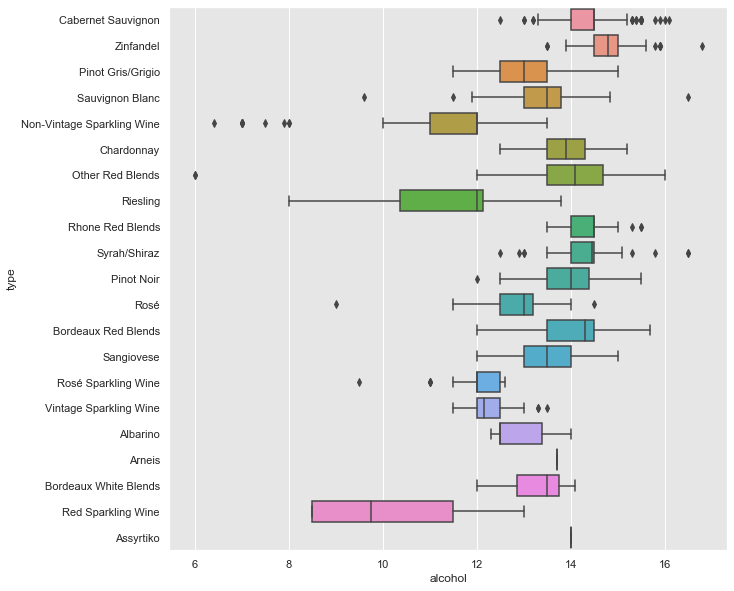

In [1426]:
fig = plt.figure(figsize=(10, 10))
sns.boxplot(y = 'type', x = 'alcohol', data = df[df.alcohol != -1]);

In [1427]:
df.category.value_counts()

Red Wine      2567
White Wine    1253
Sparkling      367
Rose           172
Unknown          7
Name: category, dtype: int64

In [1428]:
df.columns

Index(['name', 'vintage', 'country', 'region', 'type', 'category', 'alcohol',
       'base_price', 'current_price', 'discount', 'size', 'user_rating',
       'num_reviews', 'winery', 'notes', 'screw_cap', 'boutique', 'great_gift',
       'green_wine', 'collectible', 'critic_rating', 'critic_rating_num',
       'bright', 'complex', 'creamy', 'crisp', 'earth', 'elegant', 'delicate',
       'mineral', 'fruit', 'oak', 'rich', 'silky', 'smoke', 'spicy',
       'minerality', 'structure', 'toasted', 'intense', 'num_words',
       'country_cat', 'user_rating_cat', 'alcohol_cat', 'vintage_cat'],
      dtype='object')

In [1627]:
df.head()

,name,vintage,country,region,type,category,alcohol,base_price,current_price,discount,size,user_rating,num_reviews,winery,notes,screw_cap,boutique,great_gift,green_wine,collectible,critic_rating,critic_rating_num,bright,complex,creamy,crisp,earth,elegant,delicate,mineral,fruit,oak,rich,silky,smoke,spicy,minerality,structure,toasted,intense,num_words,country_cat,user_rating_cat,alcohol_cat,vintage_cat,price_cat
0,1000 Stories Bourbon Barrel Aged Prospectors' ...,2017,California,No Region Specified,Cabernet Sauvignon,Red Wine,14.9,19.99,19.99,0.0,750ML,4.4,11,1000 Stories,"In the second half of the 19th Century, explor...",0,0,0,1,0,Not Rated,3,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,4,California,great,very high,2017,inexpensive
1,1000 Stories Bourbon Barrel Aged Zinfandel 2016,2016,California,No Region Specified,Zinfandel,Red Wine,15.6,21.99,21.99,0.0,750ML,4.0,78,1000 Stories,"1,000 Stories Bourbon barrel-aged Zinfandel is...",0,0,0,0,0,Outstanding,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,California,good,very high,2016,moderate
2,1000 Stories Bourbon Barrel Aged Zinfandel 2017,2017,California,No Region Specified,Zinfandel,Red Wine,-1.0,18.99,18.99,0.0,,-1.0,0,1000 Stories,"Batch 55 embodies an opulent vintage, which sa...",0,0,0,0,0,Outstanding,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,2,California,unrated,unknown,2017,inexpensive
3,13 Celsius Pinot Grigio 2017,2017,Italy,Veneto,Pinot Gris/Grigio,White Wine,12.5,13.99,13.99,0.0,750ML,-1.0,0,13 Celsius,"Full and complex, this wine has hints of fresh...",0,0,0,0,0,Good,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Italy,unrated,low,2017,inexpensive
4,13 Celsius Sauvignon Blanc 2018,2018,New Zealand,Marlborough,Sauvignon Blanc,White Wine,13.0,12.99,12.99,0.0,750ML,-1.0,0,13 Celsius,"Vibrant aromatics of citrus, lychee, sweet her...",1,0,0,0,0,Not Rated,3,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,5,New Zealand,unrated,moderate,2018,inexpensive


In [1630]:
X = df.drop(['name', 'vintage', 'country', 'region', 'alcohol', 'current_price', 'discount',
                     'size', 'user_rating', 'winery', 'notes', 'collectible', 
                     'critic_rating', 'critic_rating_num', 'price_cat'], axis=1)
y = df['critic_rating_num']

X = pd.get_dummies(X, drop_first=False)
X.sample(10)

,base_price,num_reviews,screw_cap,boutique,great_gift,green_wine,bright,complex,creamy,crisp,earth,elegant,delicate,mineral,fruit,oak,rich,silky,smoke,spicy,minerality,structure,toasted,intense,num_words,type_,type_Albarino,type_Arneis,type_Assyrtiko,type_Bordeaux Red Blends,type_Bordeaux White Blends,type_Cabernet Sauvignon,type_Chardonnay,type_Non-Vintage Sparkling Wine,type_Other Red Blends,type_Petite Sirah,type_Pinot Gris/Grigio,type_Pinot Noir,type_Red Sparkling Wine,type_Rhone Red Blends,type_Riesling,type_Rosé,type_Rosé Sparkling Wine,type_Sangiovese,type_Sauvignon Blanc,type_Syrah/Shiraz,type_Vintage Sparkling Wine,type_Zinfandel,category_Red Wine,category_Rose,category_Sparkling,category_Unknown,category_White Wine,country_cat_Argentina,country_cat_Australia,country_cat_California,country_cat_Chile,country_cat_France,country_cat_Germany,country_cat_Italy,country_cat_New Zealand,country_cat_Oregon,country_cat_Other,country_cat_South Africa,country_cat_Spain,country_cat_Washington,user_rating_cat_fair,user_rating_cat_good,user_rating_cat_great,user_rating_cat_outstanding,user_rating_cat_poor,user_rating_cat_unrated,alcohol_cat_high,alcohol_cat_low,alcohol_cat_moderate,alcohol_cat_unknown,alcohol_cat_very high,alcohol_cat_very low,vintage_cat_2000s,vintage_cat_2010s,vintage_cat_2014,vintage_cat_2015,vintage_cat_2016,vintage_cat_2017,vintage_cat_2018,vintage_cat_None
4247,16.99,9,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2366,29.99,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
3585,19.99,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2486,14.99,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0
1211,12.99,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
506,28.99,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1639,17.99,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2821,48.99,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2590,30.00,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2702,13.99,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0


In [1433]:
X.shape

(4366, 80)

In [1434]:
4366/80

54.575

In [1432]:
cab = X.loc[3353]

In [1435]:
cab

base_price                     11.99
num_reviews                    53.00
screw_cap                       0.00
boutique                        0.00
great_gift                      0.00
green_wine                      0.00
bright                          0.00
complex                         0.00
creamy                          0.00
crisp                           0.00
earth                           0.00
elegant                         0.00
delicate                        0.00
mineral                         0.00
fruit                           0.00
oak                             0.00
rich                            1.00
silky                           0.00
smoke                           0.00
spicy                           0.00
minerality                      0.00
structure                       1.00
toasted                         0.00
intense                         0.00
num_words                       3.00
type_Albarino                   0.00
type_Arneis                     0.00
t

In [1371]:
X.describe()

,base_price,num_reviews,screw_cap,boutique,great_gift,green_wine,bright,complex,creamy,crisp,earth,elegant,delicate,mineral,fruit,oak,rich,silky,smoke,spicy,minerality,structured,toasted,intense,num_words,type_Albarino,type_Arneis,type_Assyrtiko,type_Bordeaux Red Blends,type_Bordeaux White Blends,type_Cabernet Sauvignon,type_Chardonnay,type_Non-Vintage Sparkling Wine,type_Other Red Blends,type_Petite Sirah,type_Pinot Gris/Grigio,type_Pinot Noir,type_Red Sparkling Wine,type_Rhone Red Blends,type_Riesling,type_Rosé,type_Rosé Sparkling Wine,type_Sangiovese,type_Sauvignon Blanc,type_Syrah/Shiraz,type_Vintage Sparkling Wine,type_Zinfandel,category_Rose,category_Sparkling,category_Unknown,category_White Wine,country_cat_Australia,country_cat_California,country_cat_Chile,country_cat_France,country_cat_Germany,country_cat_Italy,country_cat_New Zealand,country_cat_Oregon,country_cat_Other,country_cat_South Africa,country_cat_Spain,country_cat_Washington,user_rating_cat_good,user_rating_cat_great,user_rating_cat_outstanding,user_rating_cat_poor,user_rating_cat_unrated,alcohol_cat_low,alcohol_cat_moderate,alcohol_cat_unknown,alcohol_cat_very high,alcohol_cat_very low,vintage_cat_2010s,vintage_cat_2014,vintage_cat_2015,vintage_cat_2016,vintage_cat_2017,vintage_cat_2018,vintage_cat_None
count,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000
mean,44.453493,9.888456,0.193541,0.030692,0.012368,0.119789,0.147732,0.145213,0.059780,0.097114,0.046954,0.130554,0.069171,0.119789,0.527027,0.166972,0.206596,0.067568,0.024737,0.070545,0.062758,0.042144,0.052909,0.085433,2.329592,0.006871,0.000687,0.000687,0.113605,0.005726,0.147962,0.144068,0.048099,0.079936,0.000229,0.032753,0.115896,0.001374,0.033898,0.024049,0.039395,0.019927,0.036876,0.072148,0.028401,0.014659,0.031150,0.039395,0.084059,0.001603,0.286990,0.040999,0.428997,0.028630,0.213468,0.013972,0.091846,0.027714,0.036418,0.019698,0.015117,0.025195,0.035044,0.158956,0.191938,0.034814,0.003207,0.579707,0.074439,0.150252,0.434494,0.165369,0.027485,0.077187,0.085433,0.138571,0.227897,0.240724,0.142006,0.075126
std,84.504690,25.839644,0.395119,0.172501,0.110536,0.324752,0.354875,0.352356,0.237106,0.296147,0.211564,0.336951,0.253774,0.324752,0.499326,0.372994,0.404910,0.251031,0.155339,0.256093,0.242554,0.200940,0.223877,0.279557,1.831300,0.082617,0.026207,0.026207,0.317367,0.075462,0.355103,0.351199,0.214000,0.271225,0.015134,0.178010,0.320136,0.037050,0.180988,0.153220,0.194556,0.139764,0.188479,0.258763,0.166135,0.120196,0.173742,0.194556,0.277508,0.040014,0.452409,0.198310,0.494990,0.166784,0.409802,0.117386,0.288842,0.164171,0.187349,0.138975,0.122032,0.156734,0.183911,0.365677,0.393869,0.183331,0.056542,0.493662,0.262514,0.357359,0.495747,0.371556,0.163511,0.266919,0.279557,0.345538,0.419524,0.427572,0.349097,0.263625
min,4.970000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

## Exploratory Data Analysis

In [1458]:
color_scheme = ['#2f3848','#00c5b9', '#f05768', 'darkgray']

Target Variable
critic_rating_num
0     210
1    2056
2     227
3    1873
Name: critic_rating_num, dtype: int64


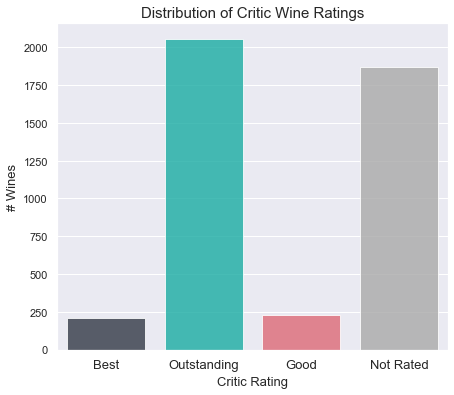

In [1459]:
# Survival Count
print('Target Variable')
print(df.groupby(['critic_rating_num']).critic_rating_num.count())

# Target Variable Countplot
sns.set_style('darkgrid')
sns.set(font_scale=1)
plt.figure(figsize = (7,6))
ax = sns.countplot(df['critic_rating_num'], alpha =.80,
                   palette= color_scheme)
ax.set_xticklabels(['Best', 'Outstanding', 'Good', 'Not Rated'], fontsize=13)
plt.title('Distribution of Critic Wine Ratings', fontsize=15)
ax.set_ylabel('# Wines', fontsize=13)
ax.set_xlabel('Critic Rating', fontsize=13)
plt.show()

In [1460]:
df.columns

Index(['name', 'vintage', 'country', 'region', 'type', 'category', 'alcohol',
       'base_price', 'current_price', 'discount', 'size', 'user_rating',
       'num_reviews', 'winery', 'notes', 'screw_cap', 'boutique', 'great_gift',
       'green_wine', 'collectible', 'critic_rating', 'critic_rating_num',
       'bright', 'complex', 'creamy', 'crisp', 'earth', 'elegant', 'delicate',
       'mineral', 'fruit', 'oak', 'rich', 'silky', 'smoke', 'spicy',
       'minerality', 'structure', 'toasted', 'intense', 'num_words',
       'country_cat', 'user_rating_cat', 'alcohol_cat', 'vintage_cat'],
      dtype='object')

In [1461]:
df.country_cat.value_counts().index

Index(['California', 'France', 'Italy', 'Australia', 'Oregon', 'Washington',
       'Chile', 'New Zealand', 'Spain', 'Argentina', 'Other', 'South Africa',
       'Germany'],
      dtype='object')

In [ ]:
df.critic_rating_num

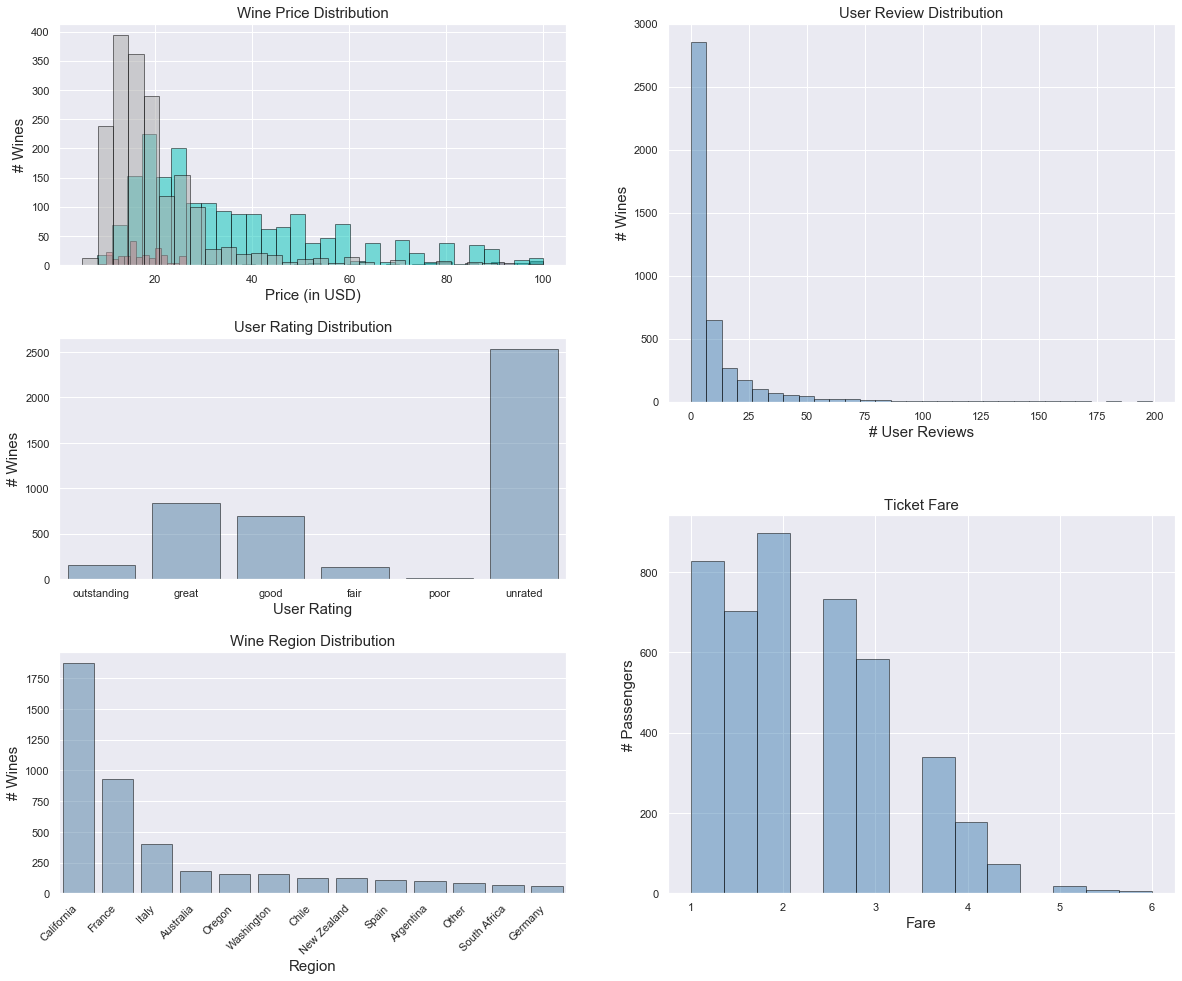

In [1608]:
# Subplots of Numeric Features
sns.set_style('darkgrid')
fig = plt.figure(figsize = (20,16))
fig.subplots_adjust(hspace = .30)

ax1 = fig.add_subplot(321)
ax1.hist(df[(df['critic_rating_num'] ==0) & (df['base_price'] <100)].base_price, bins = 30, alpha = .50,edgecolor= 'black',color =color_scheme[0])
ax1.hist(df[(df['critic_rating_num'] ==1) & (df['base_price'] <100)].base_price, bins = 30, alpha = .50,edgecolor= 'black',color =color_scheme[1])
ax1.hist(df[(df['critic_rating_num'] ==2) & (df['base_price'] <100)].base_price, bins = 30, alpha = .50,edgecolor= 'black',color =color_scheme[2])
ax1.hist(df[(df['critic_rating_num'] ==3) & (df['base_price'] <100)].base_price, bins = 30, alpha = .50,edgecolor= 'black',color =color_scheme[3])
# ax1.set_xlim(0, 400)
ax1.set_xlabel('Price (in USD)', fontsize = 15)
ax1.set_ylabel('# Wines',fontsize = 15)
ax1.set_title('Wine Price Distribution',fontsize = 15)

ax2 = fig.add_subplot(323)
sns.countplot(data = df, x='user_rating_cat', alpha = .50, edgecolor= 'black',color ='steelblue', ax = ax2,
             order = ['outstanding', 'great', 'good', 'fair', 'poor', 'unrated'])
ax2.set_xlabel('User Rating',fontsize = 15)
ax2.set_ylabel('# Wines',fontsize = 15)
ax2.set_title('User Rating Distribution',fontsize = 15)

ax3 = fig.add_subplot(325)
sns.countplot(data = df, x='country_cat', alpha = .50, edgecolor= 'black',color ='steelblue', ax = ax3,
             order = df.country_cat.value_counts().index)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, horizontalalignment='right')
ax3.set_xlabel('Region',fontsize = 15)
ax3.set_ylabel('# Wines',fontsize = 15)
ax3.set_title('Wine Region Distribution',fontsize = 15)

ax4 = fig.add_subplot(222)
ax4.hist(df[df['num_reviews']<200].num_reviews, bins = 30, alpha = .50,edgecolor= 'black',color ='steelblue')
ax4.set_xlabel('# User Reviews', fontsize = 15)
ax4.set_ylabel('# Wines',fontsize = 15)
ax4.set_title('User Review Distribution',fontsize = 15)

# ax4 = fig.add_subplot(222)
# sns.countplot(data = df, x='user_rating_cat', alpha = .50, edgecolor= 'black',color ='steelblue', ax = ax4,
#              order = ['outstanding', 'great', 'good', 'fair', 'poor', 'unrated'])
# ax4.set_xlabel('User Rating',fontsize = 15)
# ax4.set_ylabel('# Wines',fontsize = 15)
# ax4.set_title('User Rating Distribution',fontsize = 15)

ax5 = fig.add_subplot(224)
ax5.hist(df['num_words'], bins = 14, alpha = .50,edgecolor= 'black',color ='steelblue')
ax5.set_xticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14'])
ax5.set_xlabel('Fare',fontsize = 15)
ax5.set_ylabel('# Passengers',fontsize = 15)
ax5.set_title('Ticket Fare',fontsize = 15)

plt.show()

In [1618]:
df[(df['critic_rating_num']==0) & (df['base_price']<50)]

,name,vintage,country,region,type,category,alcohol,base_price,current_price,discount,size,user_rating,num_reviews,winery,notes,screw_cap,boutique,great_gift,green_wine,collectible,critic_rating,critic_rating_num,bright,complex,creamy,crisp,earth,elegant,delicate,mineral,fruit,oak,rich,silky,smoke,spicy,minerality,structure,toasted,intense,num_words,country_cat,user_rating_cat,alcohol_cat,vintage_cat,price_cat
953,Chateau Laroque (Futures Pre-Sale) 2018,2018,France,St. Emilion,Bordeaux Red Blends,Red Wine,14.5,31.97,31.97,0.0,750ML,-1.0,0,Chateau Laroque,Superbly located on one of the highest points ...,0,0,0,0,0,Best,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,France,unrated,very high,2018,within reach
1013,Chateau Marquis d'Alesme (Futures Pre-Sale) 2018,2018,France,Margaux,Bordeaux Red Blends,Red Wine,-1.0,44.97,44.97,0.0,,-1.0,0,Chateau Marquis d'Alesme,,0,0,0,0,0,Best,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,France,unrated,unknown,2018,within reach
1071,Chateau Poesia (Futures Pre-Sale) 2018,2018,France,St. Emilion,Bordeaux Red Blends,Red Wine,-1.0,33.97,33.97,0.0,,-1.0,0,Chateau Poesia,"Blend: 70% Merlot, 30% Cabernet Franc",0,0,0,0,0,Best,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,France,unrated,unknown,2018,within reach
1202,Clos de l'Oratoire (Futures Pre-Sale) 2018,2018,France,St. Emilion,Bordeaux Red Blends,Red Wine,-1.0,39.97,39.97,0.0,,-1.0,0,Clos de l'Oratoire,"Clos de l'Oratoire is round, smooth, and very ...",0,0,0,0,0,Best,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,France,unrated,unknown,2018,within reach
1516,Domaine du Vieux Telegraphe Chateauneuf-du-Pap...,2016,France,Chateauneuf-du-Pape,Rhone Red Blends,Red Wine,-1.0,49.99,49.99,0.0,,4.4,10,Domaine du Vieux Telegraphe,"One cannot think of Chateauneuf-du-Pape, the m...",0,0,0,0,0,Best,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,France,great,unknown,2016,within reach
2008,Grgich Hills Estate Chardonnay 2015,2015,California,Napa Valley,Chardonnay,White Wine,14.1,43.00,39.99,7.0,750ML,4.0,39,Grgich Hills Estate,The winemaker did not allow this Chardonnay to...,0,0,1,1,0,Best,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,3,California,good,high,2015,within reach
2084,Hartford Court Russian River Pinot Noir 2017,2017,California,Russian River,Pinot Noir,Red Wine,14.5,40.00,33.99,15.0,750ML,4.6,5,Hartford Court,"Aromas of black cherry, allspice, black curran...",0,1,0,0,0,Best,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,4,California,outstanding,very high,2017,within reach
3012,Napa Cellars Chardonnay 2016,2016,California,Napa Valley,Chardonnay,White Wine,13.9,18.99,18.99,0.0,750ML,3.7,16,Napa Cellars,The Napa Cellars 2016 Chardonnay displays the ...,0,0,0,0,0,Best,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,California,good,high,2016,inexpensive
3465,Roederer Estate L'Ermitage 2012,2012,California,Anderson Valley,Vintage Sparkling Wine,Sparkling,-1.0,49.99,49.99,0.0,,4.8,12,Roederer Estate,"L’Ermitage, Roederer Estate’s special Tête de ...",0,0,0,0,0,Best,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,California,outstanding,unknown,2010s,within reach
4261,Wente Charles Wetmore Cabernet Sauvignon 2016,2016,California,Livermore Valley,Cabernet Sauvignon,Red Wine,14.5,30.00,26.99,10.0,750ML,4.1,13,Wente Vineyards,The 2016 Charles Wetmore Cabernet Sauvignon is...,0,0,0,1,0,Best,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,California,great,very high,2016,within reach


Text(0.5, 1.0, 'Wine Price Distribution')

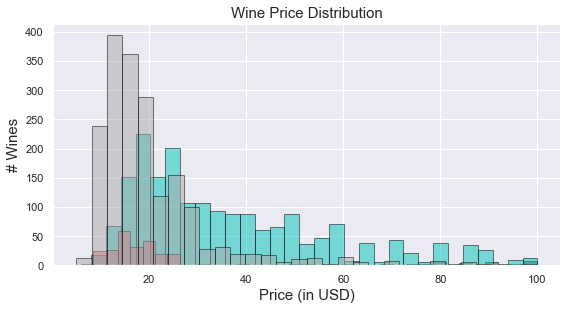

In [1625]:
sns.set_style('darkgrid')
fig = plt.figure(figsize = (20,16))
fig.subplots_adjust(hspace = .30)

ax1 = fig.add_subplot(321)
ax1.hist(df[(df['critic_rating_num'] ==0) & (df['base_price'] <100)].base_price, bins = 30, alpha = .50,edgecolor= 'black',color =color_scheme[0])
ax1.hist(df[(df['critic_rating_num'] ==1) & (df['base_price'] <100)].base_price, bins = 30, alpha = .50,edgecolor= 'black',color =color_scheme[1])
ax1.hist(df[(df['critic_rating_num'] ==2) & (df['base_price'] <100)].base_price, bins = 15, alpha = .50,edgecolor= 'black',color =color_scheme[2])
ax1.hist(df[(df['critic_rating_num'] ==3) & (df['base_price'] <100)].base_price, bins = 30, alpha = .50,edgecolor= 'black',color =color_scheme[3])
# ax1.set_xlim(0, 400)
ax1.set_xlabel('Price (in USD)', fontsize = 15)
ax1.set_ylabel('# Wines',fontsize = 15)
ax1.set_title('Wine Price Distribution by Critic Rating',fontsize = 15)

Text(0.5, 1.0, 'Wine Price Distribution')

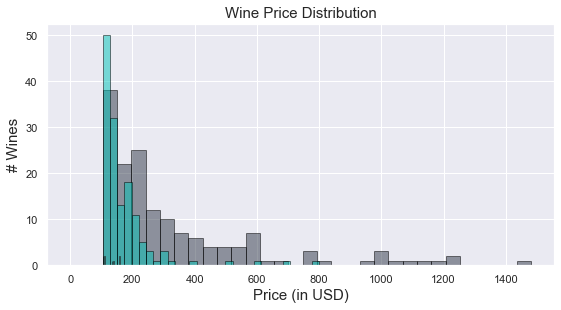

In [1612]:
sns.set_style('darkgrid')
fig = plt.figure(figsize = (20,16))
fig.subplots_adjust(hspace = .30)

ax1 = fig.add_subplot(321)
ax1.hist(df[(df['critic_rating_num'] ==0) & (df['base_price'] >100)].base_price, bins = 30, alpha = .50,edgecolor= 'black',color =color_scheme[0])
ax1.hist(df[(df['critic_rating_num'] ==1) & (df['base_price'] >100)].base_price, bins = 30, alpha = .50,edgecolor= 'black',color =color_scheme[1])
ax1.hist(df[(df['critic_rating_num'] ==2) & (df['base_price'] >100)].base_price, bins = 30, alpha = .50,edgecolor= 'black',color =color_scheme[2])
ax1.hist(df[(df['critic_rating_num'] ==3) & (df['base_price'] >100)].base_price, bins = 30, alpha = .50,edgecolor= 'black',color =color_scheme[3])
# ax1.set_xlim(0, 400)
ax1.set_xlabel('Price (in USD)', fontsize = 15)
ax1.set_ylabel('# Wines',fontsize = 15)
ax1.set_title('Wine Price Distribution',fontsize = 15)

In [ ]:
df.base_price.

In [1604]:
df['price_cat'] = df.base_price.apply(lambda x: 'cheap' if x < 10 else 'inexpensive' if x < 20 else 'moderate' if x < 30 else 'within reach' if x < 50 else 'expensive' if x < 100 else 'out of reach')

Critic Rating by Country


critic_rating_num      0      1      2       3
price_cat                                     
cheap                NaN   11.0   12.0   115.0
expensive           44.0  416.0    NaN    68.0
inexpensive          1.0  427.0  155.0  1165.0
moderate             NaN  535.0   56.0   380.0
out of reach       156.0  147.0    NaN     9.0
within reach         9.0  520.0    4.0   136.0


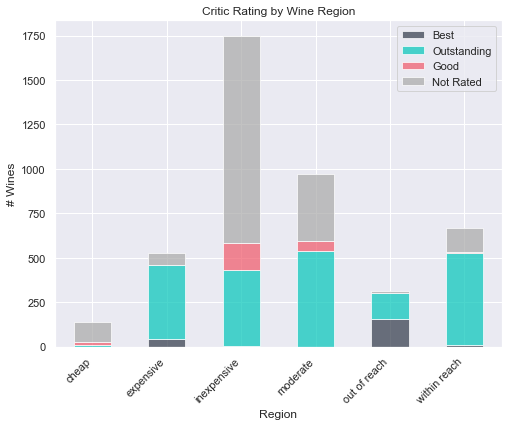

In [1605]:
# Country summary
print('Critic Rating by Country')

print('\n')
print(df.groupby(['price_cat','critic_rating_num']).price_cat.count().unstack())

# Passenger class visualization
fig = plt.figure(figsize=(8, 6))
p1 = fig.add_subplot()
region = df.groupby(['price_cat','critic_rating_num']).price_cat.count().unstack()
region.plot(kind = 'bar', ax=p1, stacked = True, 
                   title = 'Critic Rating by Wine Region', 
                   color = color_scheme, alpha = .70)
p1.set_xlabel('Region')
p1.set_ylabel('# Wines')
# p1.set_ylim((0,400))
p1.set_xticklabels(p1.get_xticklabels(), rotation=45, ha='right')
p1.legend(['Best', 'Outstanding', 'Good', 'Not Rated'])
plt.show()

Critic Rating by Country


critic_rating_num      0      1      2      3
country_cat                                  
Argentina            1.0   59.0    5.0   35.0
Australia            2.0   97.0   15.0   65.0
California          49.0  811.0  118.0  895.0
Chile                4.0   45.0    4.0   72.0
France             141.0  556.0   20.0  215.0
Germany              NaN   19.0    3.0   39.0
Italy               11.0  188.0   13.0  189.0
New Zealand          NaN   48.0    8.0   65.0
Oregon               1.0   90.0    3.0   65.0
Other                NaN   24.0    6.0   56.0
South Africa         NaN   24.0    3.0   39.0
Spain                1.0   40.0   14.0   55.0
Washington           NaN   55.0   15.0   83.0


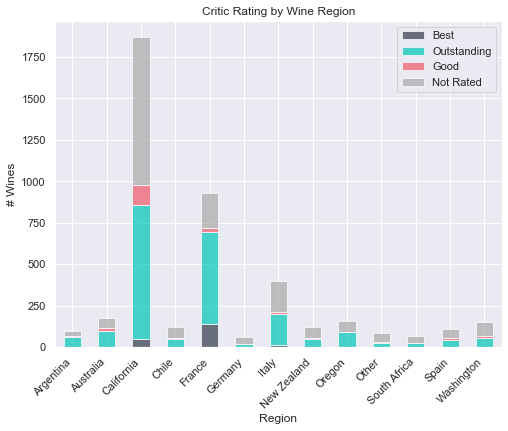

In [1463]:
# Country summary
print('Critic Rating by Country')

print('\n')
print(df.groupby(['country_cat','critic_rating_num']).country_cat.count().unstack())

# Passenger class visualization
fig = plt.figure(figsize=(8, 6))
p1 = fig.add_subplot()
region = df.groupby(['country_cat','critic_rating_num']).country_cat.count().unstack()
region.plot(kind = 'bar', ax=p1, stacked = True, 
                   title = 'Critic Rating by Wine Region', 
                   color = color_scheme, alpha = .70)
p1.set_xlabel('Region')
p1.set_ylabel('# Wines')
# p1.set_ylim((0,400))
p1.set_xticklabels(p1.get_xticklabels(), rotation=45, ha='right')
p1.legend(['Best', 'Outstanding', 'Good', 'Not Rated'])
plt.show()

Critic Rating by Wine Type


critic_rating_num               0      1     2      3
type                                                 
                              NaN    NaN   NaN    7.0
Albarino                      NaN   13.0   2.0   15.0
Arneis                        NaN    3.0   NaN    NaN
Assyrtiko                     NaN    1.0   NaN    2.0
Bordeaux Red Blends         139.0  316.0   2.0   39.0
Bordeaux White Blends         1.0   20.0   NaN    4.0
Cabernet Sauvignon           34.0  301.0  33.0  278.0
Chardonnay                    4.0  255.0  34.0  336.0
Non-Vintage Sparkling Wine    1.0  122.0   8.0   79.0
Other Red Blends              3.0  132.0  19.0  195.0
Petite Sirah                  NaN    1.0   NaN    NaN
Pinot Gris/Grigio             NaN   18.0  11.0  114.0
Pinot Noir                    4.0  266.0  17.0  219.0
Red Sparkling Wine            NaN    2.0   NaN    4.0
Rhone Red Blends              3.0   85.0  10.0   50.0
Riesling                      NaN   37.0  12.0   56.0

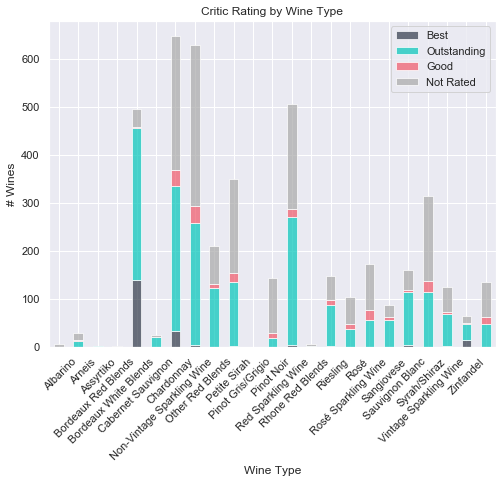

In [1464]:
# User Rating summary
print('Critic Rating by Wine Type')

print('\n')
print(df.groupby(['type','critic_rating_num']).type.count().unstack())

# Passenger class visualization
fig = plt.figure(figsize=(8, 6))
p1 = fig.add_subplot()
wine_type = df.groupby(['type','critic_rating_num']).type.count().unstack()
wine_type.plot(kind = 'bar', ax=p1, stacked = True, 
                   title = 'Critic Rating by Wine Type', 
                   color = color_scheme,
                   alpha = .70)
p1.set_xlabel('Wine Type')
p1.set_ylabel('# Wines')
p1.set_xticklabels(p1.get_xticklabels(), rotation=45, ha='right')
p1.legend(['Best', 'Outstanding', 'Good', 'Not Rated'])
plt.show()

Critic Rating by Wine Vintage


critic_rating_num     0      1     2      3
vintage_cat                                
2000s              14.0   39.0   NaN    4.0
2010s              10.0  177.0  10.0  140.0
2014               10.0  214.0  19.0  130.0
2015               31.0  324.0  19.0  231.0
2016               32.0  496.0  59.0  408.0
2017               46.0  411.0  71.0  523.0
2018               66.0  220.0  32.0  302.0
None                1.0  175.0  17.0  135.0


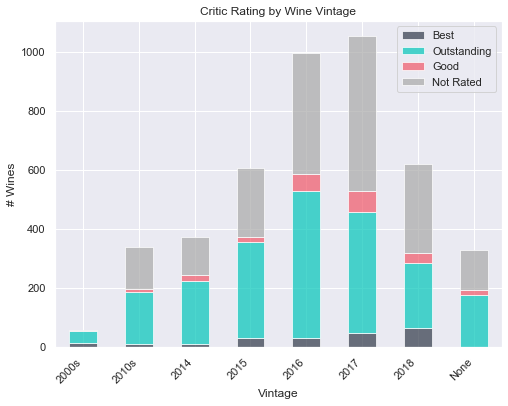

In [1465]:
# User Rating summary
print('Critic Rating by Wine Vintage')

print('\n')
print(df.groupby(['vintage_cat','critic_rating_num']).vintage_cat.count().unstack())

# Passenger class visualization
fig = plt.figure(figsize=(8, 6))
p1 = fig.add_subplot()
vintage = df.groupby(['vintage_cat','critic_rating_num']).vintage_cat.count().unstack()
vintage.plot(kind = 'bar', ax=p1, stacked = True, 
                   title = 'Critic Rating by Wine Vintage', 
                   color = color_scheme,
                   alpha = .70)
p1.set_xlabel('Vintage')
p1.set_ylabel('# Wines')
p1.set_xticklabels(p1.get_xticklabels(), rotation=45, ha='right')
p1.legend(['Best', 'Outstanding', 'Good', 'Not Rated'])
plt.show()

In [1466]:
df2 = df.copy()
df2 = df2.astype({'num_words': object})
df2.num_words.dtype

dtype('O')

Critic Rating by Number of Descriptors Used


critic_rating_num     0      1     2      3
num_words                                  
0                  87.0  395.0  22.0  323.0
1                  30.0  297.0  39.0  338.0
2                  22.0  400.0  68.0  407.0
3                  27.0  323.0  43.0  339.0
4                  21.0  291.0  34.0  238.0
5                  13.0  177.0  13.0  137.0
6                   6.0  108.0   5.0   59.0
7                   4.0   45.0   1.0   24.0
8                   NaN    9.0   1.0    7.0
9                   NaN    7.0   1.0    NaN
10                  NaN    4.0   NaN    1.0


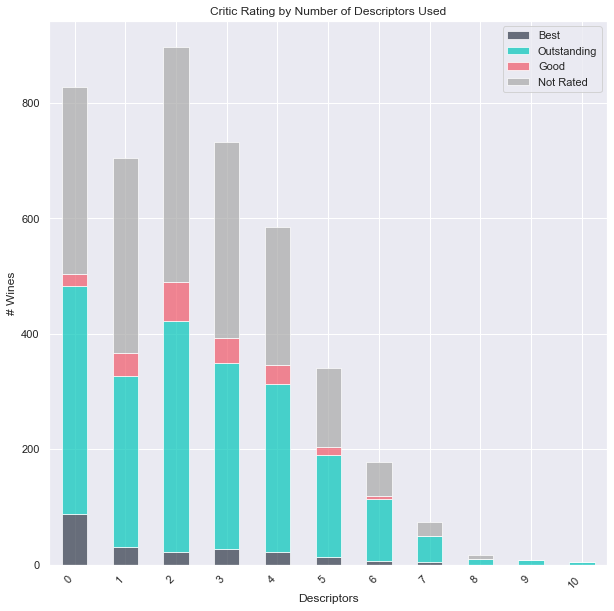

In [1467]:
# User Rating summary
print('Critic Rating by Number of Descriptors Used')

print('\n')
print(df.groupby(['num_words','critic_rating_num']).num_words.count().unstack())

# Passenger class visualization
fig = plt.figure(figsize=(10, 10))
p1 = fig.add_subplot()
num_words = df.groupby(['num_words','critic_rating_num']).num_words.count().unstack()
num_words.plot(kind = 'bar', ax=p1, stacked = True, 
                   title = 'Critic Rating by Number of Descriptors Used', 
                   color = color_scheme,
                   alpha = .70)
p1.set_xlabel('Descriptors')
p1.set_ylabel('# Wines')
p1.set_xticklabels(p1.get_xticklabels(), rotation=45, ha='right')
p1.legend(['Best', 'Outstanding', 'Good', 'Not Rated'])
plt.show()

In [1468]:
wine_notes

['bright',
 'complex',
 'creamy',
 'crisp',
 'earth',
 'elegant',
 'delicate',
 'mineral',
 'fruit',
 'oak',
 'rich',
 'silky',
 'smoke',
 'spicy',
 'minerality',
 'structure',
 'toasted',
 'rich',
 'intense']

In [1469]:
for i in range(1,10):
    print(int(str(len(wine_notes)//3)+str(len(wine_notes)%3)+str(i)))

611
612
613
614
615
616
617
618
619


In [1470]:
for i, word in enumerate(wine_notes):
    # Passenger class visualization
    fig = plt.figure(figsize=(6, 6))
    p1 = fig.add_subplot(int(str(len(wine_notes)//3)+str(len(wine_notes)%3)+str(i)))
    num_words = df.groupby([word,'critic_rating_num'])
    num_words = num_words[word].count().unstack()
    num_words.plot(kind = 'bar', ax=p1, stacked = True, 
                       title = 'Critic Rating by the Use of the Word ' + word, 
                       color = ['steelblue','mediumseagreen', 'palevioletred', 'darkgray'],
                       alpha = .70)
    p1.set_xlabel('Did the Wine Description Use this Word?')
    p1.set_ylabel('# Wines')
    p1.set_xticklabels(p1.get_xticklabels(), rotation=45, ha='right')
    p1.legend(['Best', 'Outstanding', 'Good', 'Not Rated'])
    plt.show()

ValueError: num must be 1 <= num <= 6, not 0

<Figure size 432x432 with 0 Axes>

## Scaling and Creating X and y arrays

In [1646]:
train_scaler = MinMaxScaler()
test_scaler = MinMaxScaler()

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=10)

x_train_scaled = train_scaler.fit_transform(x_train)
x_test_scaled = test_scaler.fit_transform(x_test)

y_train_binary = y_train.map(lambda x: 0 if x == 3 else 1)
y_test_binary = y_test.map(lambda x: 0 if x == 3 else 1)

In [1483]:
x_train.loc[3553]

base_price                     26.0
num_reviews                    11.0
screw_cap                       0.0
boutique                        0.0
great_gift                      0.0
green_wine                      0.0
bright                          0.0
complex                         1.0
creamy                          0.0
crisp                           0.0
earth                           0.0
elegant                         0.0
delicate                        1.0
mineral                         0.0
fruit                           0.0
oak                             1.0
rich                            1.0
silky                           0.0
smoke                           0.0
spicy                           0.0
minerality                      0.0
structure                       0.0
toasted                         0.0
intense                         1.0
num_words                       6.0
type_Albarino                   0.0
type_Arneis                     0.0
type_Assyrtiko              

### SMOTE to Balance Classes

In [1069]:
smt = SMOTE()
x_SMOTE, y_SMOTE = smt.fit_sample(X, y)

train_scaler_SMOTE = MinMaxScaler()
test_scaler_SMOTE = MinMaxScaler()

x_train_SMOTE, x_test_SMOTE, y_train_SMOTE, y_test_SMOTE = train_test_split(x_SMOTE, y_SMOTE, random_state=10)

x_train_SMOTE_scaled = train_scaler.fit_transform(x_train_SMOTE)
x_test_SMOTE_scaled = test_scaler.fit_transform(x_test_SMOTE)

In [1070]:
y.value_counts()

1    1797
3    1587
0     203
2     189
Name: critic_rating_num, dtype: int64

### Upsampling to Balance Classes

In [1642]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=10)

In [1643]:
# Separate majority and minority classes
df_0 = df[df['critic_rating_num']==0]
df_1 = df[df['critic_rating_num']==1]
df_2 = df[df['critic_rating_num']==2]
df_3 = df[df['critic_rating_num']==3]
 
# Upsample minority classes
df_0_upsampled = resample(df_0, 
                                 replace=True,     # sample with replacement
                                 n_samples=1797,    # to match majority class
                                 random_state=10) # reproducible results
df_2_upsampled = resample(df_2, 
                                 replace=True,     # sample with replacement
                                 n_samples=1797,    # to match majority class
                                 random_state=10) # reproducible results

df_3_upsampled = resample(df_3, 
                                 replace=True,     # sample with replacement
                                 n_samples=1797,    # to match majority class
                                 random_state=10) # reproducible results

# Combine majority class with upsampled minority classes
df_upsampled = pd.concat([df_0_upsampled, df_2_upsampled, df_3_upsampled, df_1])
 
# Display new class counts
df_upsampled.critic_rating_num.value_counts()

1    2056
3    1797
2    1797
0    1797
Name: critic_rating_num, dtype: int64

In [1644]:
X_upsampled = df_upsampled.drop(['name', 'vintage', 'country', 'region', 'alcohol', 'current_price', 'discount',
                     'size', 'user_rating', 'winery', 'notes', 'collectible', 
                     'critic_rating', 'critic_rating_num', 'price_cat'], axis=1)
X_upsampled = pd.get_dummies(X_upsampled, drop_first=True)
y_upsampled = df_upsampled.critic_rating_num

train_scaler_upsampling = MinMaxScaler()
test_scaler_upsampling = MinMaxScaler()

x_train_upsampling, x_test_upsampling, y_train_upsampling, y_test_upsampling = train_test_split(X_upsampled,
                                                                                                y_upsampled,
                                                                                                random_state=10)

x_train_scaled_upsampling = train_scaler.fit_transform(x_train_upsampling)
x_test_scaled_upsampling = test_scaler.fit_transform(x_test_upsampling)

## Creating Ordinal Classes

In [1073]:
class OrdinalClassifier():
    
    def __init__(self, clf):
        self.clf = clf
        self.clfs = {}
        
    def get_feature_importances(self, n):
        all_fi = []
        if n == len(self.clfs):
            for k in range(n):
                all_fi.append(self.clfs[k].feature_importances_)
            return sum(all_fi)/len(all_fi)
        else:
            return self.clfs[n].feature_importances_
    
    def fit(self, X, y):
        self.unique_class = np.sort(np.unique(y))
        if self.unique_class.shape[0] > 2:
            for i in range(self.unique_class.shape[0]-1):
                # for each k - 1 ordinal value we fit a binary classification problem
                binary_y = (y > self.unique_class[i]).astype(np.uint8)
                clf = clone(self.clf)
                clf.fit(X, binary_y)
                self.clfs[i] = clf
    
    def predict_proba(self, X):
        clfs_predict = {k:self.clfs[k].predict_proba(X) for k in self.clfs}
        predicted = []
        for i,y in enumerate(self.unique_class):
            if i == 0:
                # V1 = 1 - Pr(y > V1)
                predicted.append(1 - clfs_predict[y][:,1])
            elif y in clfs_predict:
                # Vi = Pr(y > Vi-1) - Pr(y > Vi)
                 predicted.append(clfs_predict[y-1][:,1] - clfs_predict[y][:,1])
            else:
                # Vk = Pr(y > Vk-1)
                predicted.append(clfs_predict[y-1][:,1])
        return np.vstack(predicted).T
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)
    
#     def get_score(self):
#         for k in len(self.clfs):
#             self.clfs[k].score
#         .score(x_train_scaled, y_train)


## Logistic Regression - Binary

In [1563]:
cab

base_price                     11.99
num_reviews                    53.00
screw_cap                       0.00
boutique                        0.00
great_gift                      0.00
green_wine                      0.00
bright                          0.00
complex                         0.00
creamy                          0.00
crisp                           0.00
earth                           0.00
elegant                         0.00
delicate                        0.00
mineral                         0.00
fruit                           0.00
oak                             0.00
rich                            1.00
silky                           0.00
smoke                           0.00
spicy                           0.00
minerality                      0.00
structure                       1.00
toasted                         0.00
intense                         0.00
num_words                       3.00
type_Albarino                   0.00
type_Arneis                     0.00
t

In [1564]:
y_train_pred_base = np.full(y_train.shape, 1)
y_test_pred_base = np.full(y_test.shape, 1)

In [1565]:
logreg = LogisticRegression(fit_intercept = False, C = 1e12, solver='liblinear')
model_log = logreg.fit(x_train_scaled, y_train)
y_train_pred = model_log.predict(x_train_scaled)
y_test_pred = model_log.predict(x_test_scaled)

# y_score = logreg.decision_function(x_test_scaled)
# fpr, tpr, thresholds = roc_curve(y_test_binary, y_score)

/Users/kathringo/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [1566]:
# y_score = logreg.fit(x_train_scaled, y_train_binary).decision_function(x_test_scaled)

In [1567]:
# mean_squared_error(y_train_binary, y_train_pred)

In [1570]:
y_pred_cab = model_log.predict(np.array(cab).reshape(1,-1))
y_pred_cab

array([0])

In [1542]:
def get_model_metrics(y_train, y_train_pred, y_test, y_test_pred):

    print(f"Accuracy Score (Training): {round(accuracy_score(y_train, y_train_pred)*100)}%")
    print(f"Accuracy Score (Testing): {round(accuracy_score(y_test, y_test_pred)*100)}%")

    print(f"Recall Score (Training): {round(recall_score(y_train, y_train_pred, average='weighted')*100)}%")
    print(f"Recall Score (Testing): {round(recall_score(y_test, y_test_pred, average='weighted')*100)}%")

    print(f"Precision Score (Training): {round(precision_score(y_train, y_train_pred, average='weighted')*100)}%")
    print(f"Precision Score (Testing): {round(precision_score(y_test, y_test_pred, average='weighted')*100)}%")

    print(f"F1-Score (Training): {round(f1_score(y_train, y_train_pred, average='weighted')*100)}%")
    print(f"F1-Score (Testing): {round(f1_score(y_test, y_test_pred, average='weighted')*100)}%")
    
#     print(f"Training Mean Squared Error: {round(mean_squared_error(y_train_binary, y_train_pred),2)}")
#     print(f"Testing Mean Squared Error: {round(mean_squared_error(y_test_binary, y_test_pred),2)}")


In [1078]:
def get_confusion_matrix()

SyntaxError: invalid syntax (<ipython-input-1078-9c0e8f43c2c0>, line 1)

In [1543]:
print(classification_report(y_test, y_test_pred_base))
get_model_metrics(y_train, y_train_pred_base, y_test, y_test_pred_base)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        49
           1       0.49      1.00      0.66       540
           2       0.00      0.00      0.00        56
           3       0.00      0.00      0.00       447

    accuracy                           0.49      1092
   macro avg       0.12      0.25      0.17      1092
weighted avg       0.24      0.49      0.33      1092

Accuracy Score (Training): 46.0%
Accuracy Score (Testing): 49.0%
Recall Score (Training): 46.0%
Recall Score (Testing): 49.0%
Precision Score (Training): 21.0%
Precision Score (Testing): 24.0%
F1-Score (Training): 29.0%
F1-Score (Testing): 33.0%


/Users/kathringo/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kathringo/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kathringo/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [1544]:
get_model_metrics(y_train, y_train_pred, y_test, y_test_pred)

Accuracy Score (Training): 72.0%
Accuracy Score (Testing): 68.0%
Recall Score (Training): 72.0%
Recall Score (Testing): 68.0%
Precision Score (Training): 71.0%
Precision Score (Testing): 65.0%
F1-Score (Training): 71.0%
F1-Score (Testing): 66.0%


In [1545]:
# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_test_pred, rownames=['True'], colnames=['Predicted'], margins=True)


Confusion Matrix
----------------


Predicted,0,1,3,All
True,,,,
0,35,14,0,49
1,31,395,114,540
2,0,23,33,56
3,0,133,314,447
All,66,565,461,1092


In [200]:
pd.Series(y_train_rand).value_counts()

2    304
1    290
5    274
4    260
3    252
dtype: int64

In [1101]:
cnf_matrix_train = confusion_matrix(y_train, y_train_pred)
cnf_matrix_test = confusion_matrix(y_test, y_test_pred)

In [1224]:
def plot_confusion_matrix(y, y_pred):
    
    cnf_matrix = confusion_matrix(y, y_pred)
    plt.imshow(cnf_matrix,  cmap=plt.cm.RdPu) #Create the basic matrix.
    #Add title and Axis Labels
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    #Add appropriate Axis Scales
    class_names = ['Best', 'Outstanding', 'Good', 'Unrated']#set(y) #Get class labels to add to matrix
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    #Add Labels to Each Cell
    thresh = cnf_matrix.max() / 2. #Used for text coloring below
    #Here we iterate through the confusion matrix and append labels to our visualization.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
            plt.text(j, i, cnf_matrix[i, j],
                     horizontalalignment="center",
                     color="white" if cnf_matrix[i, j] > thresh else "black", fontsize=13, fontweight='bold')

    #Add a Side Bar Legend Showing Colors
    plt.colorbar()
    plt.show();

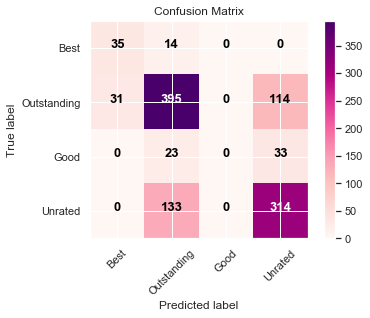

In [1546]:
plot_confusion_matrix(y_test, y_test_pred)

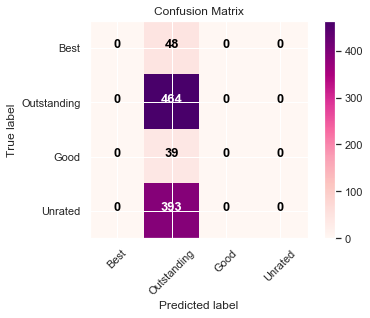

In [1228]:
plot_confusion_matrix(y_test, y_test_pred_base)

In [248]:
# x_test.loc[y_test_binary != y_test_pred, 'base_price'].mean()

In [247]:
# x_test.loc[y_test_binary == y_test_pred, 'base_price'].mean()

In [246]:
# x_test[y_test_binary != y_test_pred]

In [1088]:
def plot_roc_curve():
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    print('AUC: {}'.format(auc(fpr, tpr)))
    plt.figure(figsize=(10,8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show();

AUC: 0.8457812074276241


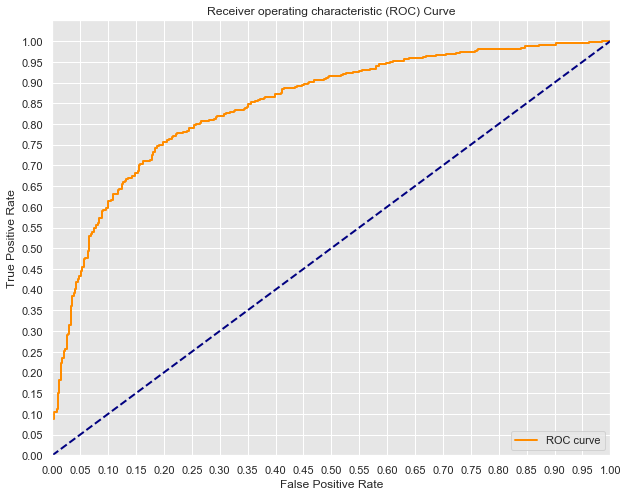

In [1089]:
plot_roc_curve()

## Logistic Regression - Categories

In [1571]:
logreg = OrdinalClassifier(LogisticRegression(fit_intercept = False))
# logreg.fit(x_train_upscaled, y_train_upscaled)
logreg.fit(x_train_scaled, y_train)
y_train_pred = logreg.predict(x_train_scaled)
y_test_pred = logreg.predict(x_test_scaled)

# y_score = logreg.decision_function(x_test_scaled)
# fpr, tpr, thresholds = roc_curve(y_test, y_score)

/Users/kathringo/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathringo/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathringo/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [1579]:
y_pred_cab = logreg.predict(np.array(cab).reshape(1,-1))
y_pred_cab[0]

0

In [1578]:
np.array(cab).reshape(1,-1)

array([[11.99, 53.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  3.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ]])

In [251]:
# y_score = logreg.fit(x_train_scaled, y_train).decision_function(x_test_scaled)
# y_score

/Users/kathringo/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


array([[  2.17058959,   4.4861071 ,  -0.34951517, -15.07329404],
       [ -0.19341063,  -0.17201257,   0.1466927 ,   0.22121831],
       [ -0.23557689,  -0.14909934,  -0.02076999,   0.81186709],
       ...,
       [ -0.29977329,   0.66446203,  -0.22066602,  -0.34267366],
       [  0.62764775,   0.11140313,  -0.14483489,  -2.89294985],
       [  0.02378257,  -0.41880715,   0.24309114,   0.03983018]])

In [1105]:
# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_test_pred, rownames=['True'], colnames=['Predicted'], margins=True)


Confusion Matrix
----------------


Predicted,0,1,3,All
True,,,,
0,20,27,1,48
1,12,337,115,464
2,0,14,25,39
3,0,120,273,393
All,32,498,414,944


In [1106]:
get_model_metrics(y_train, y_train_pred, y_test, y_test_pred)

Accuracy Score (Training): 68.0%
Accuracy Score (Testing): 67.0%
Recall Score (Training): 68.0%
Recall Score (Testing): 67.0%
Precision Score (Training): 70.0%
Precision Score (Testing): 64.0%
F1-Score (Training): 66.0%
F1-Score (Testing): 65.0%


/Users/kathringo/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kathringo/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [1113]:
logreg = OrdinalClassifier(LogisticRegression(fit_intercept = False))
logreg.fit(x_train_upsampling, y_train_upsampling)
# logreg.fit(x_train_scaled, y_train)
y_train_pred = logreg.predict(x_train_upsampling)
y_test_pred = logreg.predict(x_test)

/Users/kathringo/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathringo/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kathringo/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: X has 80 features per sample; expecting 88

In [1114]:
get_model_metrics(y_train_upsampling, y_train_pred, y_test_upsampling, y_test_pred)

Accuracy Score (Training): 70.0%
Accuracy Score (Testing): 69.0%
Recall Score (Training): 70.0%
Recall Score (Testing): 69.0%
Precision Score (Training): 70.0%
Precision Score (Testing): 69.0%
F1-Score (Training): 69.0%
F1-Score (Testing): 69.0%


In [1115]:
# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_test_pred, rownames=['True'], colnames=['Predicted'], margins=True)


Confusion Matrix
----------------


ValueError: could not broadcast input array from shape (1797) into shape (944)

## Decision Tree Classifier

In [258]:
clf.clfs

{0: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=None, splitter='best'),
 1: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=None, splitter='best'),
 2: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                        max_features=None, max_leaf_nodes=None,
                        mi

In [1580]:
# import logging
clf = OrdinalClassifier(DecisionTreeClassifier(random_state=10))
clf.fit(x_train_scaled, y_train)
# clf.fit(x_train_SMOTE, y_train_SMOTE)
# breakpoint()
y_train_pred = clf.predict(x_train_scaled)
y_test_pred = clf.predict(x_test_scaled)

In [1594]:
y_pred_non_cab = clf.predict(np.array(X.iloc[3]).reshape(1,-1))
y_pred_non_cab



array([0])

In [1595]:
X.iloc[2]

base_price                     18.99
num_reviews                     0.00
screw_cap                       0.00
boutique                        0.00
great_gift                      0.00
green_wine                      0.00
bright                          0.00
complex                         0.00
creamy                          0.00
crisp                           0.00
earth                           1.00
elegant                         0.00
delicate                        0.00
mineral                         0.00
fruit                           1.00
oak                             0.00
rich                            0.00
silky                           0.00
smoke                           0.00
spicy                           0.00
minerality                      0.00
structure                       0.00
toasted                         0.00
intense                         0.00
num_words                       2.00
type_Albarino                   0.00
type_Arneis                     0.00
t

In [1582]:
y_pred_cab = clf.predict(np.array(cab).reshape(1,-1))
y_pred_cab

array([0])

In [373]:
clf = DecisionTreeClassifier(criterion='entropy', random_state=10)
# clf.fit(x_train_scaled, y_train)
clf.fit(x_train_SMOTE, y_train_SMOTE)

y_pred = clf.predict(x_test_scaled)

In [1117]:
# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_test_pred, rownames=['True'], colnames=['Predicted'], margins=True)


Confusion Matrix
----------------


Predicted,0,1,2,3,All
True,,,,,
0,39,7,2,0,48
1,56,320,44,44,464
2,0,15,9,15,39
3,3,160,62,168,393
All,98,502,117,227,944


In [1118]:
get_model_metrics(y_train, y_train_pred, y_test, y_test_pred)

Accuracy Score (Training): 100.0%
Accuracy Score (Testing): 57.0%
Recall Score (Training): 100.0%
Recall Score (Testing): 57.0%
Precision Score (Training): 100.0%
Precision Score (Testing): 64.0%
F1-Score (Training): 100.0%
F1-Score (Testing): 58.0%


In [1227]:
y_train_pred_base = np.full(y_train.shape, 1)
y_test_pred_base = np.full(y_test.shape, 1)

In [499]:
# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_test_pred_base, rownames=['True'], colnames=['Predicted'], margins=True)


Confusion Matrix
----------------


Predicted,3,All
True,,
0,10,10
1,209,209
2,17,17
3,224,224
All,460,460


In [500]:
get_model_metrics(y_train, y_train_pred_base, y_test, y_test_pred_base)

Accuracy Score (Training): 46.0%
Accuracy Score (Testing): 49.0%
Recall Score (Training): 46.0%
Recall Score (Testing): 49.0%
Precision Score (Training): 21.0%
Precision Score (Testing): 24.0%
F1-Score (Training): 29.0%
F1-Score (Testing): 32.0%


/Users/kathringo/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kathringo/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [504]:
get_model_metrics(y_train, y_train_pred, y_test, y_test_pred,)

Accuracy Score (Training): 100.0%
Accuracy Score (Testing): 59.0%
Recall Score (Training): 100.0%
Recall Score (Testing): 59.0%
Precision Score (Training): 100.0%
Precision Score (Testing): 65.0%
F1-Score (Training): 100.0%
F1-Score (Testing): 61.0%


In [1209]:
def plot_feature_importances(model, n):
    n_features = X.shape[1]
    plt.figure(figsize=(25,8))
    plt.bar(range(n_features), model.get_feature_importances(n), align='center', color=color_scheme[1]) 
    plt.xticks(np.arange(n_features), X.columns.values, ha="right", rotation=45, fontsize=11) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

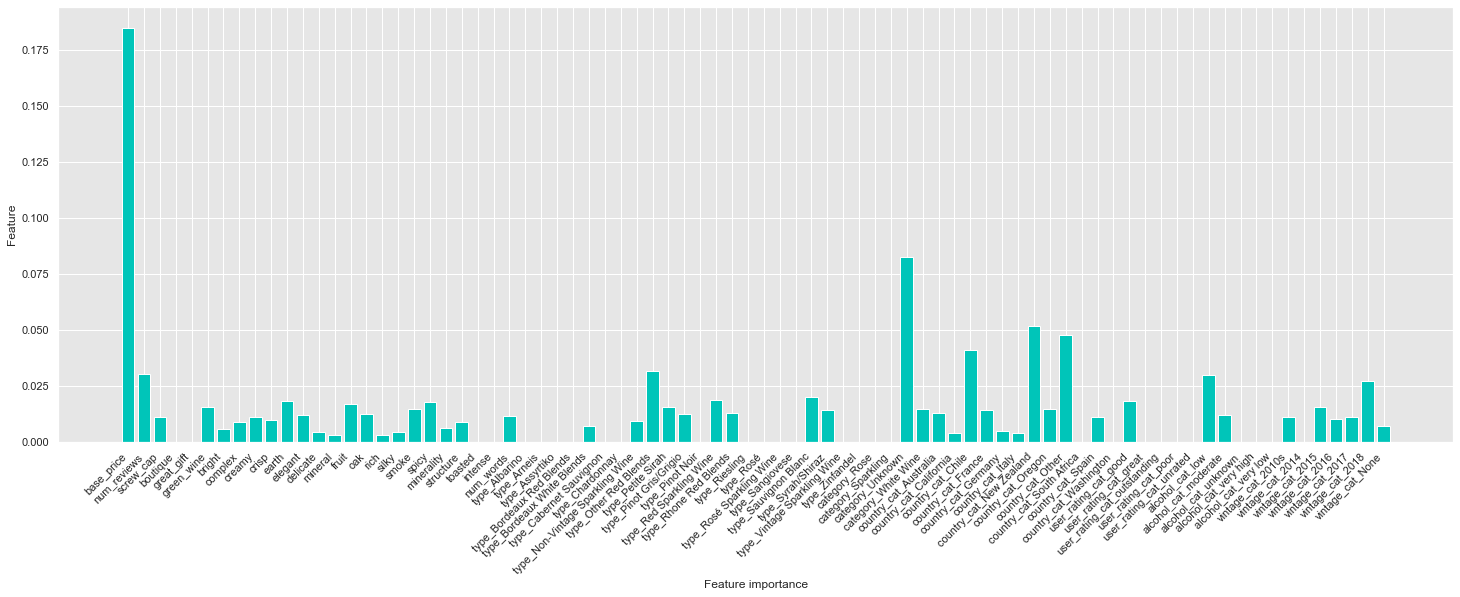

In [1440]:
plot_feature_importances(clf, 3)

In [1126]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.40      0.81      0.53        48
           1       0.64      0.69      0.66       464
           2       0.08      0.23      0.12        39
           3       0.74      0.43      0.54       393

    accuracy                           0.57       944
   macro avg       0.46      0.54      0.46       944
weighted avg       0.64      0.57      0.58       944



In [375]:
# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)


Confusion Matrix
----------------


Predicted,1,2,3,4,All
True,,,,,
1,4,3,0,0,7
2,20,107,24,49,200
3,0,6,8,9,23
4,2,67,65,96,230
All,26,183,97,154,460


/Users/kathringo/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Accuracy is :67.17391304347827

Confusion Matrix
----------------
Predicted   1    2    4  All
True                        
1           3    4    0    7
2          15  138   47  200
3           0    4   19   23
4           1   61  168  230
All        19  207  234  460


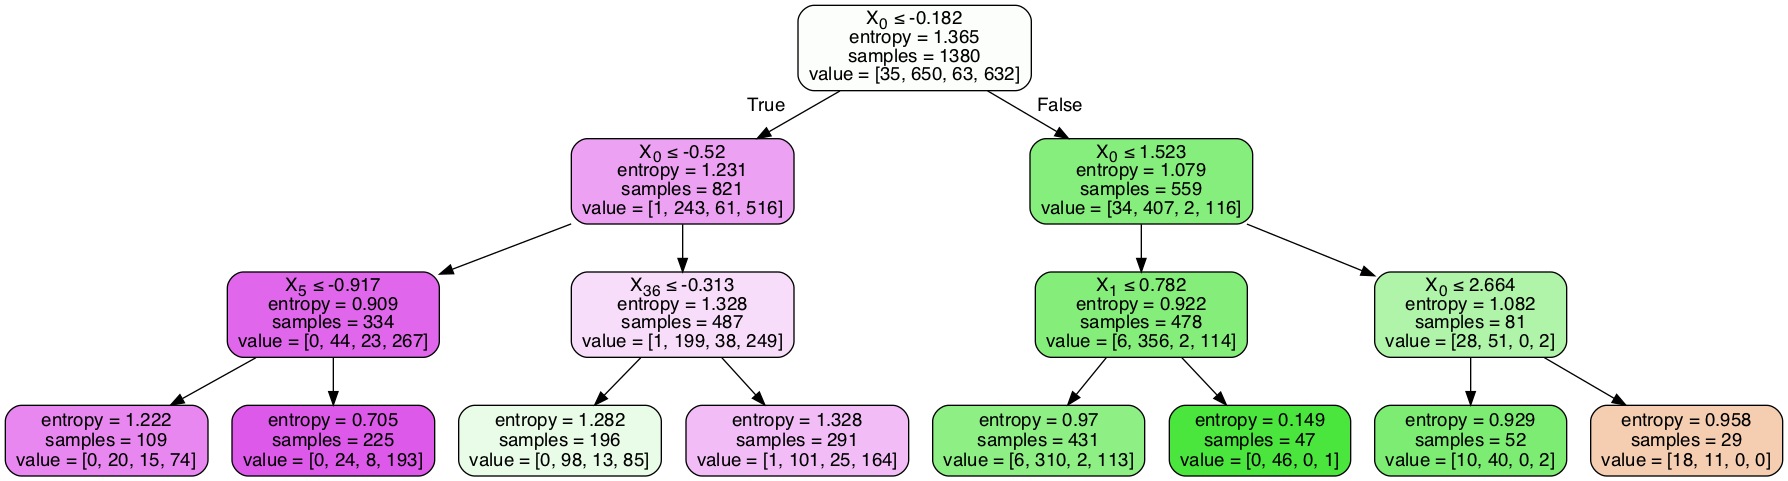

In [337]:



x_train_scaled_df = pd.DataFrame(x_train_scaled, columns = x_train.columns)
x_test_scaled_df = pd.DataFrame(x_test_scaled, columns = x_test.columns)

# Train a DT classifier
classifier2 = DecisionTreeClassifier(random_state=10, criterion='entropy', max_depth=3)  
classifier2.fit(x_train_scaled_df, y_train)  
# Make predictions for test data
y_pred = classifier2.predict(x_test_scaled_df) 
# Calculate Accuracy 
acc = accuracy_score(y_test,y_pred) * 100
print("Accuracy is :{0}".format(acc))
# # Check the AUC for predictions
# false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
# roc_auc = auc(false_positive_rate, true_positive_rate)
# print("\nAUC is :{0}".format(round(roc_auc,2)))
# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
print(pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

# Visualize the tree trained from complete dataset (optional)
dot_data = StringIO()
export_graphviz(classifier2, out_file=dot_data, filled=True, rounded=True,special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## Emsemble Methods

## Bagged Trees

In [1130]:
bagged_tree =  BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), n_estimators=20)
bagged_tree.fit(x_train_scaled, y_train) 
# bagged_tree.fit(x_train_SMOTE, y_train_SMOTE) 

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=5,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='best'),
       

In [1131]:
y_train_pred = bagged_tree.predict(x_train_scaled)
y_pred = bagged_tree.predict(x_test_scaled)
print(bagged_tree.score(x_train_scaled, y_train_pred))
print(classification_report(y_test, y_pred))

1.0
              precision    recall  f1-score   support

           0       0.66      0.79      0.72        48
           1       0.64      0.89      0.75       464
           2       0.00      0.00      0.00        39
           3       0.78      0.49      0.60       393

    accuracy                           0.68       944
   macro avg       0.52      0.54      0.52       944
weighted avg       0.67      0.68      0.65       944



/Users/kathringo/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [1133]:
# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)


Confusion Matrix
----------------


Predicted,0,1,3,All
True,,,,
0,38,10,0,48
1,20,411,33,464
2,0,17,22,39
3,0,200,193,393
All,58,638,248,944


## Random Forest

In [1134]:
forest = OrdinalClassifier(RandomForestClassifier(n_estimators = 100, random_state =10))
# forest.fit(x_train_SMOTE, y_train_SMOTE)
forest.fit(x_train_scaled, y_train)
y_train_pred = forest.predict(x_train_scaled)
y_pred = forest.predict(x_test_scaled)

In [1135]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.71      0.64        48
           1       0.69      0.84      0.76       464
           2       0.50      0.03      0.05        39
           3       0.79      0.63      0.70       393

    accuracy                           0.71       944
   macro avg       0.64      0.55      0.54       944
weighted avg       0.72      0.71      0.70       944



In [1136]:
# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)


Confusion Matrix
----------------


Predicted,0,1,2,3,All
True,,,,,
0,34,14,0,0,48
1,25,391,0,48,464
2,0,19,1,19,39
3,0,144,1,248,393
All,59,568,2,315,944


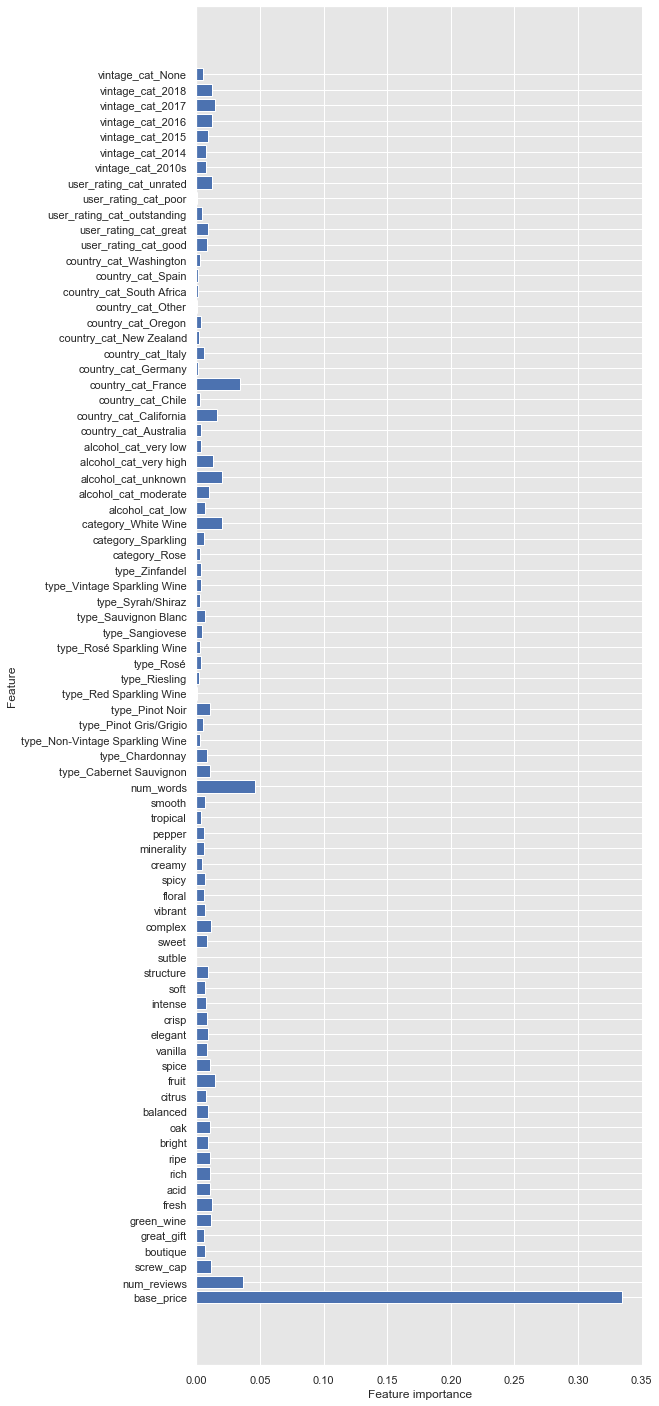

In [1137]:
plot_feature_importances(forest, 3)

In [1139]:
forest = OrdinalClassifier(RandomForestClassifier(n_estimators = 100, random_state =10))
forest.fit(x_train_upsampling, y_train_upsampling)
# forest.fit(x_train_scaled, y_train)
y_train_pred = forest.predict(x_train_upsampling)
y_pred = forest.predict(x_test_upsampling)

In [1141]:
print(classification_report(y_test_upsampling, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       449
           1       0.87      0.77      0.82       457
           2       0.96      1.00      0.98       449
           3       0.83      0.86      0.84       442

    accuracy                           0.91      1797
   macro avg       0.91      0.91      0.91      1797
weighted avg       0.91      0.91      0.91      1797



In [1142]:
# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test_upsampling, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)


Confusion Matrix
----------------


Predicted,0,1,2,3,All
True,,,,,
0,449,0,0,0,449
1,14,351,11,81,457
2,0,0,449,0,449
3,0,52,8,382,442
All,463,403,468,463,1797


ValueError: shape mismatch: objects cannot be broadcast to a single shape

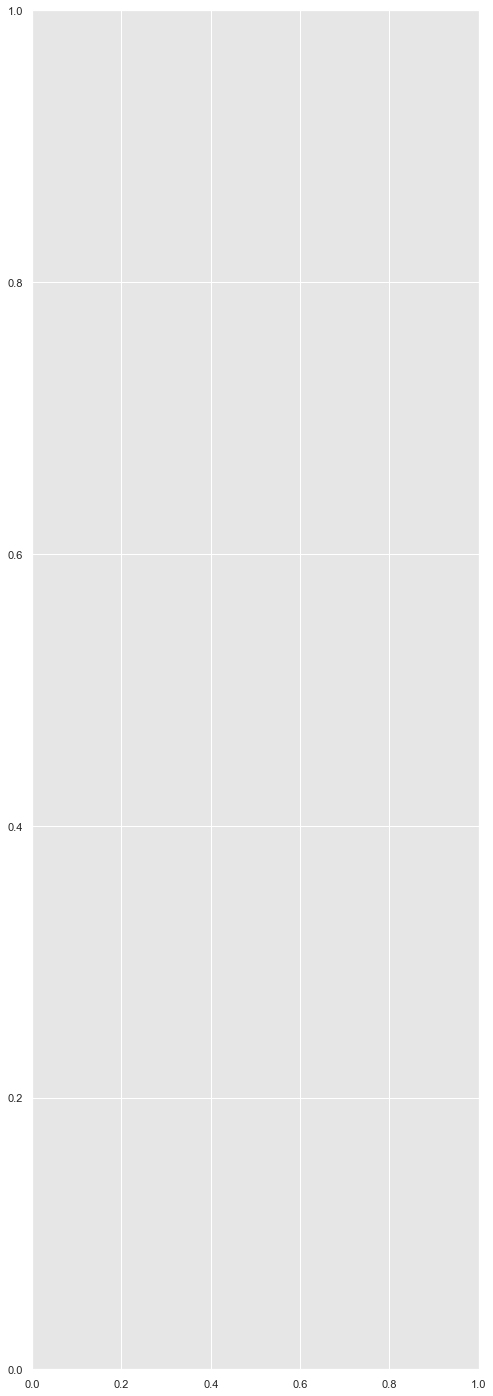

In [1143]:
plot_feature_importances(forest, 3)

## Grid Search

In [1484]:
dt_clf = DecisionTreeClassifier(random_state=10)
# breakpoint()
dt_cv_score = cross_val_score(dt_clf, x_train_scaled, y_train, cv=5)
mean_dt_cv_score = np.mean(dt_cv_score)

print(f"Mean Cross Validation Score: {mean_dt_cv_score :.2%}")

Mean Cross Validation Score: 61.21%


In [1485]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6, 8, 10, 13, 15],
    'min_samples_split': [2, 5, 10, 13, 15],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9]
}

In [1486]:
dt_grid_search = GridSearchCV(dt_clf, dt_param_grid, cv=3, return_train_score=True)
dt_grid_search.fit(x_train_scaled, y_train)
# dt_grid_search.fit(x_train_SMOTE, y_train_SMOTE)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=10,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4, 5, 6, 8, 10, 13, 15],
   

In [1147]:
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])
dt_gs_testing_score = dt_grid_search.score(x_test_scaled, y_test)
# dt_gs_testing_score = dt_grid_search.score(x_train_scaled, y_train)

print(f"Mean Training Score: {dt_gs_training_score :.2%}")
print(f"Mean Testing Score: {dt_gs_testing_score :.2%}")
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Training Score: 75.52%
Mean Testing Score: 62.82%
Best Parameter Combination Found During Grid Search:


{'criterion': 'entropy',
 'max_depth': 8,
 'min_samples_leaf': 7,
 'min_samples_split': 15}

In [1148]:
# import logging
clf = OrdinalClassifier(DecisionTreeClassifier(random_state=10, criterion='entropy',
                                               max_depth=8, min_samples_leaf=7,
                                               min_samples_split=15))
clf.fit(x_train_scaled, y_train)
y_train_pred = clf.predict(x_train_scaled)
y_test_pred = clf.predict(x_test_scaled)
print(classification_report(y_test, y_test_pred))
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_test_pred, rownames=['True'], colnames=['Predicted'], margins=True)

In [1149]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.41      0.81      0.55        48
           1       0.68      0.76      0.72       464
           2       0.13      0.15      0.14        39
           3       0.77      0.55      0.64       393

    accuracy                           0.65       944
   macro avg       0.50      0.57      0.51       944
weighted avg       0.68      0.65      0.65       944



In [1150]:
# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_test_pred, rownames=['True'], colnames=['Predicted'], margins=True)


Confusion Matrix
----------------


Predicted,0,1,2,3,All
True,,,,,
0,39,9,0,0,48
1,50,353,14,47,464
2,0,14,6,19,39
3,6,146,26,215,393
All,95,522,46,281,944


In [564]:
dt_clf = DecisionTreeClassifier(random_state=10)
dt_cv_score = cross_val_score(dt_clf, x_train_SMOTE, y_train_SMOTE, cv=5)
mean_dt_cv_score = np.mean(dt_cv_score)

print(f"Mean Cross Validation Score: {mean_dt_cv_score :.2%}")

dt_clf = OrdinalClassifier(DecisionTreeClassifier(random_state=10))

Mean Cross Validation Score: 75.83%


In [565]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6, 8, 10, 13, 15],
    'min_samples_split': [2, 5, 10, 13, 15],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9]
}

In [566]:
dt_grid_search = GridSearchCV(dt_clf, dt_param_grid, cv=3, return_train_score=True)
# dt_grid_search.fit(x_train_scaled, y_train)
dt_grid_search.fit(x_train_SMOTE, y_train_SMOTE)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <__main__.OrdinalClassifier object at 0x1a22cf9f98> does not.

In [549]:
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])
dt_gs_testing_score = dt_grid_search.score(x_test_scaled, y_test)
# dt_gs_testing_score = dt_grid_search.score(x_train_scaled, y_train)

print(f"Mean Training Score: {dt_gs_training_score :.2%}")
print(f"Mean Testing Score: {dt_gs_testing_score :.2%}")
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Training Score: 76.28%
Mean Testing Score: 46.74%
Best Parameter Combination Found During Grid Search:


{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [557]:
# import logging
clf = OrdinalClassifier(DecisionTreeClassifier(random_state=10, criterion='gini',
                                               max_depth=None, min_samples_leaf=1,
                                               min_samples_split=2))
# clf.fit(x_train_scaled, y_train)
clf.fit(x_train_SMOTE, y_train_SMOTE)
# breakpoint()
y_train_pred = clf.predict(x_train_scaled)
y_test_pred = clf.predict(x_test_scaled)

In [558]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.07      0.50      0.12        10
           1       0.62      0.35      0.45       209
           2       0.07      0.65      0.13        17
           3       0.77      0.42      0.54       224

    accuracy                           0.40       460
   macro avg       0.38      0.48      0.31       460
weighted avg       0.66      0.40      0.48       460



In [560]:
# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_test_pred, rownames=['True'], colnames=['Predicted'], margins=True)


Confusion Matrix
----------------


Predicted,0,1,2,3,All
True,,,,,
0,5,4,1,0,10
1,53,73,57,26,209
2,0,4,11,2,17
3,14,36,80,94,224
All,72,117,149,122,460


In [1487]:
rf_clf = RandomForestClassifier()
mean_rf_cv_score = np.mean(cross_val_score(rf_clf, x_train_scaled, y_train, cv=3))

print(f"Mean Cross Validation Score for Random Forest Classifier: {mean_rf_cv_score :.2%}")

Mean Cross Validation Score for Random Forest Classifier: 69.15%


/Users/kathringo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/kathringo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/kathringo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [1488]:
rf_param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

In [1489]:
import time
start = time.time()
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=3)
rf_grid_search.fit(x_train_scaled, y_train)

print(f"Testing Accuracy: {rf_grid_search.best_score_ :.2%}")
print(f"Total Runtime for Grid Search on Random Forest Classifier: {time.time() - start :.2f} seconds")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Testing Accuracy: 71.81%
Total Runtime for Grid Search on Random Forest Classifier: 20.60 seconds

Optimal Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}


In [1596]:
# rf_clf = RandomForestClassifier(random_state=10, criterion='entropy', max_depth=None,
#                                min_samples_leaf = 3, min_samples_split=5,
#                                 n_estimators=100)
# mean_rf_cv_score = np.mean(cross_val_score(rf_clf, x_train_scaled, y_train, cv=3))

rf_clf = RandomForestClassifier(
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state=10, criterion='entropy', max_depth=None,
                               min_samples_leaf = 3, min_samples_split=5,
                                n_estimators=100)
rf_clf.fit(x_train_scaled, y_train)
print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf_clf.score(x_train_scaled, y_train), 
                                                                                             rf_clf.oob_score_,
                                                                                             rf_clf.score(x_test_scaled, y_test)))
# print(f"Mean Cross Validation Score for Random Forest Classifier: {mean_rf_cv_score :.2%}")

R^2 Training Score: 0.83 
OOB Score: 0.72 
R^2 Validation Score: 0.72


In [1600]:
rf_clf.predict(np.array(cab).reshape(1,-1))


array([1])

In [1597]:
y_train_pred = rf_clf.predict(x_train_scaled)
y_test_pred = rf_clf.predict(x_test_scaled)
print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.94      0.58      0.72       161
           1       0.84      0.90      0.87      1516
           2       0.00      0.00      0.00       171
           3       0.82      0.90      0.86      1426

    accuracy                           0.83      3274
   macro avg       0.65      0.59      0.61      3274
weighted avg       0.79      0.83      0.81      3274

              precision    recall  f1-score   support

           0       0.67      0.57      0.62        49
           1       0.73      0.80      0.76       540
           2       0.00      0.00      0.00        56
           3       0.71      0.72      0.72       447

    accuracy                           0.72      1092
   macro avg       0.53      0.52      0.52      1092
weighted avg       0.68      0.72      0.70      1092



/Users/kathringo/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [1552]:
# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_test_pred, rownames=['True'], colnames=['Predicted'], margins=True)


Confusion Matrix
----------------


Predicted,0,1,3,All
True,,,,
0,28,21,0,49
1,14,431,95,540
2,0,18,38,56
3,0,124,323,447
All,42,594,456,1092


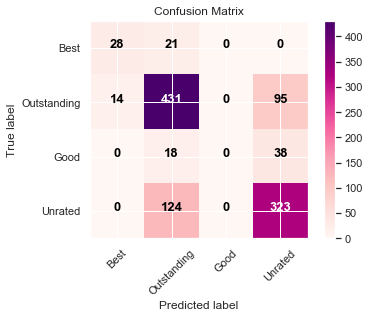

In [1553]:
plot_confusion_matrix(y_test, y_test_pred)

Text(0, 0.5, 'Feature')

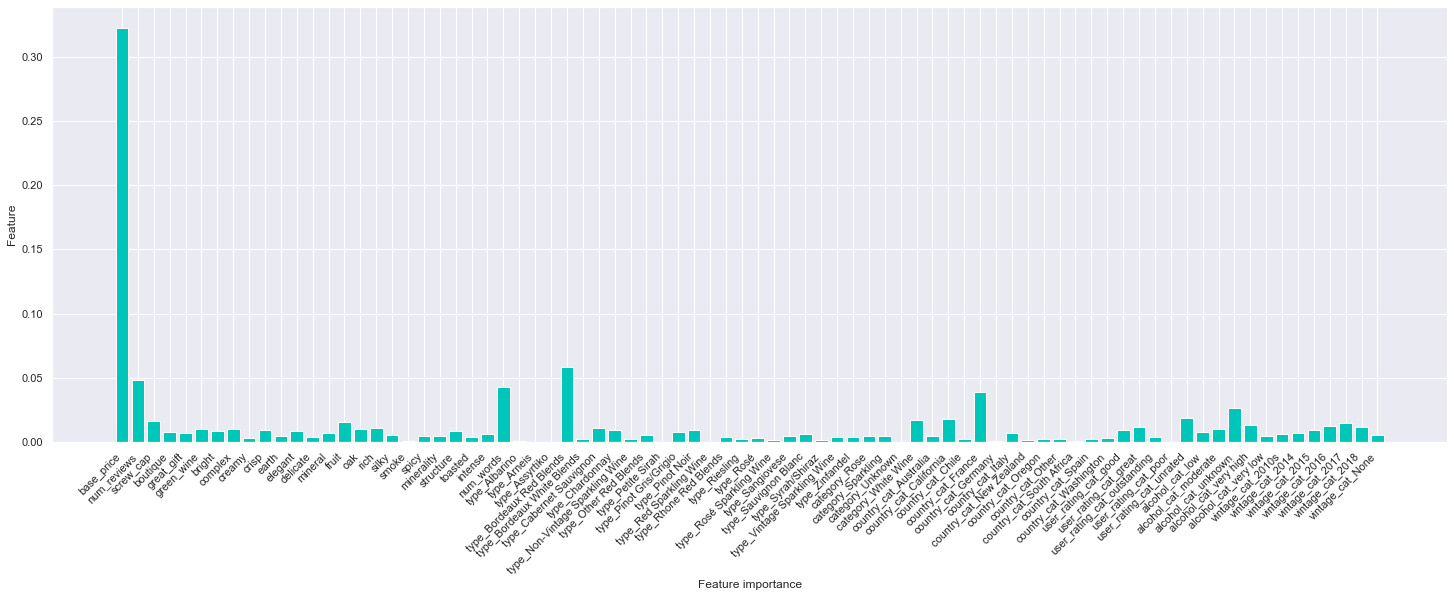

In [1555]:

n_features = X.shape[1]
plt.figure(figsize=(25,8))
plt.bar(range(n_features), rf_clf.feature_importances_, align='center', color=color_scheme[1]) 
plt.xticks(np.arange(n_features), X.columns.values, ha="right", rotation=45, fontsize=11) 
plt.xlabel("Feature importance")
plt.ylabel("Feature")

## AdaBoost (Gradient Boosted Trees)

In [1158]:
adaboost_clf = AdaBoostClassifier()
adaboost_mean_cv_score = np.mean(cross_val_score(adaboost_clf, x_train_scaled, y_train, cv=3))

print(f"Mean Cross Validation Score for AdaBoost: {adaboost_mean_cv_score :.2%}")

Mean Cross Validation Score for AdaBoost: 55.12%


In [1159]:
adaboost_param_grid = {
    'n_estimators': [50, 100, 250],
    'learning_rate': [0.5, 0.3, 0.1]
}

In [1160]:
start = time.time()
adaboost_grid_search = GridSearchCV(adaboost_clf, adaboost_param_grid, cv=3)
adaboost_grid_search.fit(x_train_scaled, y_train)

print(f"Testing Accuracy: {adaboost_grid_search.best_score_ :.2%}")
print(f"Total Runtime for Grid Search on AdaBoost: {time.time() - start :.2f} seconds")
print("")
print(f"Optimal Parameters: {adaboost_grid_search.best_params_}")

Testing Accuracy: 62.36%
Total Runtime for Grid Search on AdaBoost: 9.76 seconds

Optimal Parameters: {'learning_rate': 0.1, 'n_estimators': 100}


In [ ]:
clf = OrdinalClassifier(AdaBoostClassifier(random_state=10, learning_rate=0.1, n_estimators=100))

In [1193]:
clf = OrdinalClassifier(AdaBoostClassifier(random_state=10, learning_rate=0.1, n_estimators=100))
clf.fit(x_train_scaled, y_train)
y_train_pred = clf.predict(x_train_scaled)
y_test_pred = clf.predict(x_test_scaled)
print(classification_report(y_test, y_test_pred))
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_test_pred, rownames=['True'], colnames=['Predicted'], margins=True)

              precision    recall  f1-score   support

           0       0.29      0.92      0.44        48
           1       0.00      0.00      0.00       464
           2       0.00      0.00      0.00        39
           3       0.48      0.97      0.65       393

    accuracy                           0.45       944
   macro avg       0.19      0.47      0.27       944
weighted avg       0.22      0.45      0.29       944


Confusion Matrix
----------------


/Users/kathringo/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Predicted,0,3,All
True,,,
0,44,4,48
1,100,364,464
2,0,39,39
3,10,383,393
All,154,790,944


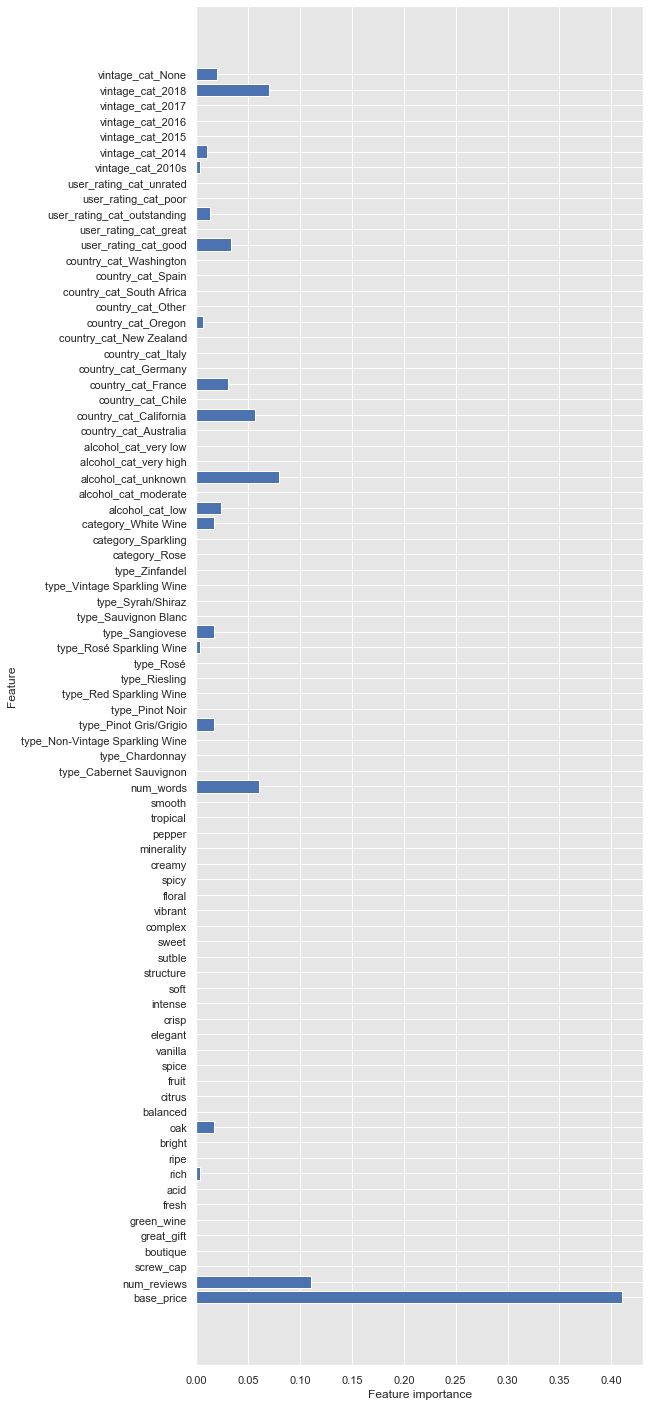

In [1194]:
plot_feature_importances(clf, 3)

## Gradient Boost

In [1170]:
gbt_clf = GradientBoostingClassifier()
gbt_clf.fit(x_train_scaled, y_train)
gbt_clf_train_preds = gbt_clf.predict(x_train_scaled)
gbt_clf_test_preds = gbt_clf.predict(x_test_scaled)

In [1171]:
def display_acc_and_f1_score(true, preds, model_name):
    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds)
    print("Model: {}".format(model_name))
    print("Accuracy: {}".format(acc))
    print("F1-Score: {}".format(f1))
    
print("Training Metrics")
display_acc_and_f1_score(y_train_binary, gbt_clf_train_preds, model_name='Gradient Boosted Trees')
print("")
print("Testing Metrics")
display_acc_and_f1_score(y_test_binary, gbt_clf_test_preds, model_name='Gradient Boosted Trees')

Training Metrics


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [1172]:
gradient_classification_report = classification_report(y_test_binary, gbt_clf_test_preds)
print(gradient_classification_report)

              precision    recall  f1-score   support

           0       0.03      0.01      0.01       393
           1       0.70      0.73      0.71       551
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

    accuracy                           0.43       944
   macro avg       0.18      0.18      0.18       944
weighted avg       0.42      0.43      0.42       944



/Users/kathringo/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [1169]:
print('Mean GBT Cross-Val Score (k=5):')
print(cross_val_score(gbt_clf, x_train_scaled, y_train, cv=5).mean())

Mean GBT Cross-Val Score (k=5):
0.7203329124773405


In [1196]:
gbt_clf = GradientBoostingClassifier()
clf.fit(x_train_scaled, y_train)
y_train_pred = clf.predict(x_train_scaled)
y_test_pred = clf.predict(x_test_scaled)
print(classification_report(y_test, y_test_pred))
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_test_pred, rownames=['True'], colnames=['Predicted'], margins=True)

              precision    recall  f1-score   support

           0       0.29      0.92      0.44        48
           1       0.00      0.00      0.00       464
           2       0.00      0.00      0.00        39
           3       0.48      0.97      0.65       393

    accuracy                           0.45       944
   macro avg       0.19      0.47      0.27       944
weighted avg       0.22      0.45      0.29       944


Confusion Matrix
----------------


/Users/kathringo/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Predicted,0,3,All
True,,,
0,44,4,48
1,100,364,464
2,0,39,39
3,10,383,393
All,154,790,944


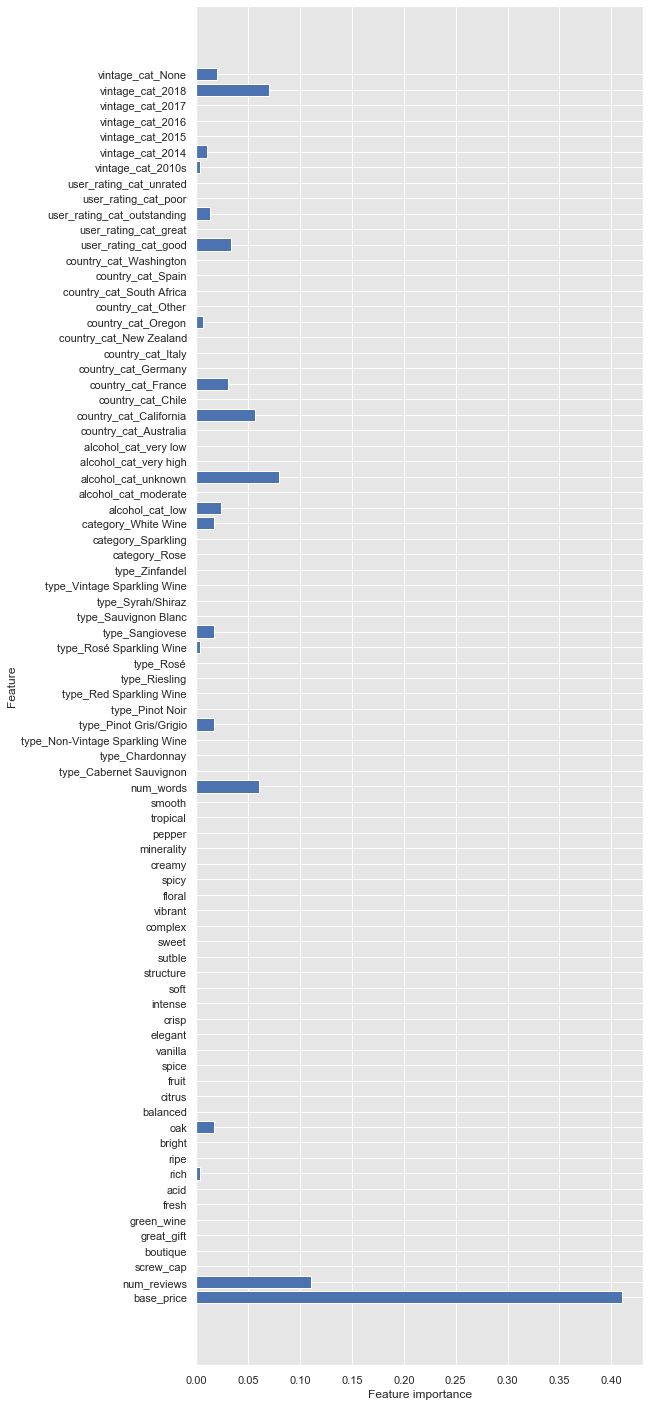

In [1197]:
plot_feature_importances(clf, 3)

## XGBoost

In [1632]:
clf = xgb.XGBClassifier()
clf.fit(x_train_scaled, y_train)
training_preds = clf.predict(x_train_scaled)
val_preds = clf.predict(x_test_scaled)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Training Accuracy: 76.3%
Validation accuracy: 71.06%


In [1633]:
param_grid = {
    "learning_rate": [0.1],
    'max_depth': [6],
    'min_child_weight': [10],
    'subsample': [ 0.7],
    'n_estimators': [5, 30, 100, 250],
}

In [1634]:
grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(x_train_scaled, y_train)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(x_train_scaled)
val_preds = grid_clf.predict(x_test_scaled)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

/Users/kathringo/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 6
min_child_weight: 10
n_estimators: 100
subsample: 0.7

Training Accuracy: 80.88%
Validation accuracy: 70.33%


In [1635]:
clf = xgb.XGBClassifier()#random_state=10, learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=30, subsample=0.7)
clf.fit(x_train_scaled, y_train)
y_train_pred = clf.predict(x_train_scaled)
y_test_pred = clf.predict(x_test_scaled)
print(classification_report(y_test, y_test_pred))
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_test_pred, rownames=['True'], colnames=['Predicted'], margins=True)

              precision    recall  f1-score   support

           0       0.50      0.82      0.62        49
           1       0.73      0.78      0.75       540
           2       0.00      0.00      0.00        56
           3       0.73      0.70      0.71       447

    accuracy                           0.71      1092
   macro avg       0.49      0.57      0.52      1092
weighted avg       0.68      0.71      0.69      1092


Confusion Matrix
----------------


/Users/kathringo/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Predicted,0,1,3,All
True,,,,
0,40,9,0,49
1,39,423,78,540
2,0,17,39,56
3,1,133,313,447
All,80,582,430,1092


In [ ]:
x_train_scaled_upsampling

In [1648]:
clf = OrdinalClassifier(xgb.XGBClassifier())#random_state=10, learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=30, subsample=0.7))
clf.fit(x_train_scaled_upsampling, y_train_upsampling)
y_test_pred = clf.predict(x_test_scaled_upsampling)
print(classification_report(y_test_upsampling, y_test_pred))
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_test_pred, rownames=['True'], colnames=['Predicted'], margins=True)

              precision    recall  f1-score   support

           0       0.89      0.92      0.91       456
           1       0.72      0.65      0.68       514
           2       0.65      0.82      0.72       468
           3       0.71      0.55      0.62       424

    accuracy                           0.74      1862
   macro avg       0.74      0.74      0.73      1862
weighted avg       0.74      0.74      0.73      1862


Confusion Matrix
----------------


ValueError: could not broadcast input array from shape (1862) into shape (1092)

In [1636]:
clf = OrdinalClassifier(xgb.XGBClassifier())#random_state=10, learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=30, subsample=0.7))
clf.fit(x_train_scaled, y_train)
y_train_pred = clf.predict(x_train_scaled)
y_test_pred = clf.predict(x_test_scaled)
print(classification_report(y_test, y_test_pred))
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_test_pred, rownames=['True'], colnames=['Predicted'], margins=True)

              precision    recall  f1-score   support

           0       0.51      0.82      0.63        49
           1       0.73      0.79      0.76       540
           2       0.00      0.00      0.00        56
           3       0.73      0.70      0.72       447

    accuracy                           0.71      1092
   macro avg       0.49      0.58      0.53      1092
weighted avg       0.68      0.71      0.70      1092


Confusion Matrix
----------------


Predicted,0,1,3,All
True,,,,
0,40,9,0,49
1,37,425,78,540
2,0,18,38,56
3,1,131,315,447
All,78,583,431,1092


In [1640]:
clf = OrdinalClassifier(xgb.XGBClassifier(random_state=10, learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=30, subsample=0.7))
clf.fit(x_train_scaled, y_train)
y_train_pred = clf.predict(x_train_scaled)
y_test_pred = clf.predict(x_test_scaled)
print(classification_report(y_test, y_test_pred))
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_test_pred, rownames=['True'], colnames=['Predicted'], margins=True)

              precision    recall  f1-score   support

           0       0.51      0.80      0.62        49
           1       0.72      0.76      0.74       540
           2       0.00      0.00      0.00        56
           3       0.71      0.71      0.71       447

    accuracy                           0.70      1092
   macro avg       0.49      0.57      0.52      1092
weighted avg       0.67      0.70      0.69      1092

Predicted    0     1  2     3   All
True                               
0          106    55  0     0   161
1           33  1179  1   303  1516
2            0    40  0   131   171
3            0   266  0  1160  1426
All        139  1540  1  1594  3274

Confusion Matrix
----------------


Predicted,0,1,3,All
True,,,,
0,39,10,0,49
1,36,413,91,540
2,0,19,37,56
3,1,129,317,447
All,76,571,445,1092


In [1641]:
print(classification_report(y_train, y_train_pred))
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_train, y_train_pred, rownames=['True'], colnames=['Predicted'], margins=True)


              precision    recall  f1-score   support

           0       0.76      0.66      0.71       161
           1       0.77      0.78      0.77      1516
           2       0.00      0.00      0.00       171
           3       0.73      0.81      0.77      1426

    accuracy                           0.75      3274
   macro avg       0.56      0.56      0.56      3274
weighted avg       0.71      0.75      0.73      3274


Confusion Matrix
----------------


Predicted,0,1,2,3,All
True,,,,,
0,106,55,0,0,161
1,33,1179,1,303,1516
2,0,40,0,131,171
3,0,266,0,1160,1426
All,139,1540,1,1594,3274


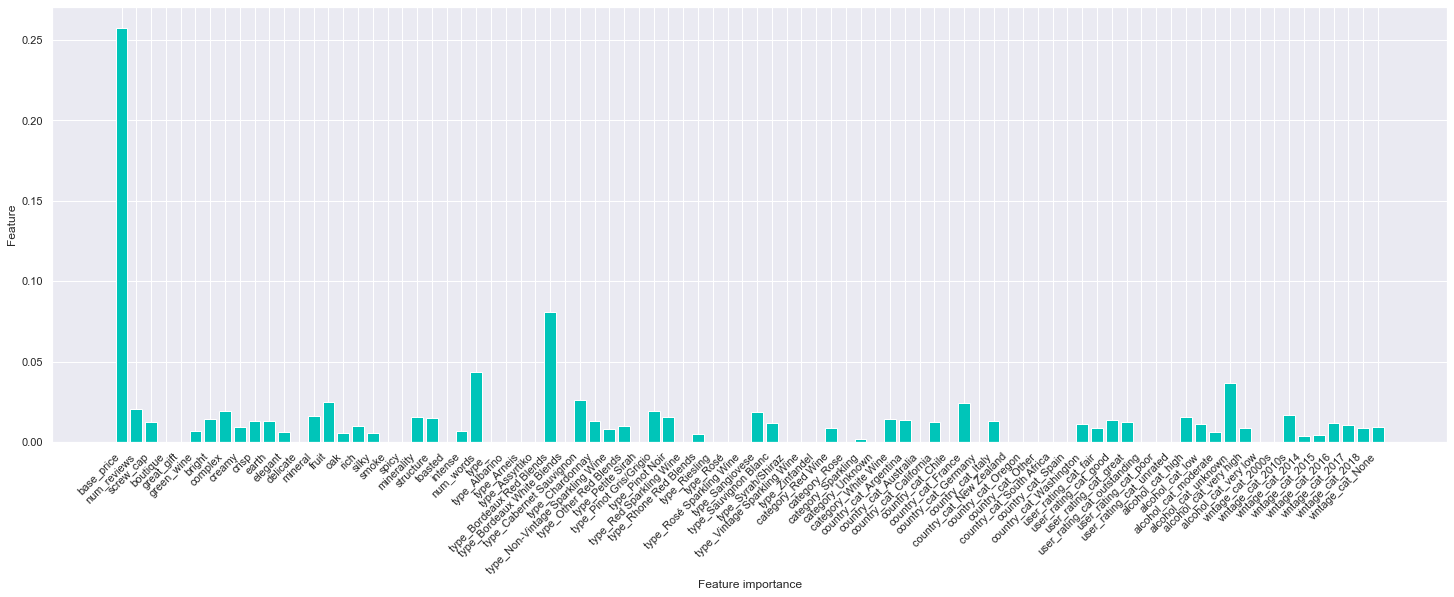

In [1638]:
plot_feature_importances(clf, 3)

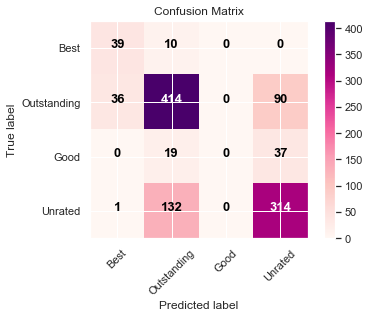

In [1506]:
plot_confusion_matrix(y_test, y_test_pred)

In [1556]:
y_test_pred_cab = clf.predict(cab)

In [1558]:
y_test_pred_cab

array([0])

In [1524]:
predictions = pd.DataFrame(y_test_pred).reset_index()

In [1525]:
actual = pd.DataFrame(y_test).reset_index()

In [1532]:
pd_pred.head()

,index,critic_rating_num,index,0
0,936,1,0,3
1,3003,3,1,3
2,2643,3,2,3
3,997,1,3,1
4,4081,3,4,3


In [1528]:
pd_pred = pd.concat([actual, predictions], axis=1)

In [1537]:
df.iloc[2537]

name                 Laurent-Perrier Grand Siecle No. 24 with Gift Box
vintage                                                           None
country                                                         France
region                                                       Champagne
type                                        Non-Vintage Sparkling Wine
category                                                     Sparkling
alcohol                                                             -1
base_price                                                      159.97
current_price                                                   159.97
discount                                                             0
size                                                                  
user_rating                                                         -1
num_reviews                                                          0
winery                                                 Laurent Perrier
notes 

In [1539]:
# pd_pred[pd_pred[0] == 0]

In [1538]:
# pd_pred[(pd_pred['critic_rating_num'] == 3)]# & (pd_pred[pd_pred[0] == 0])]

In [1511]:
x_train[(x_train['base_price'] == 11.99) & (x_train['num_reviews'] == 53)]

,base_price,num_reviews,screw_cap,boutique,great_gift,green_wine,bright,complex,creamy,crisp,earth,elegant,delicate,mineral,fruit,oak,rich,silky,smoke,spicy,minerality,structure,toasted,intense,num_words,type_Albarino,type_Arneis,type_Assyrtiko,type_Bordeaux Red Blends,type_Bordeaux White Blends,type_Cabernet Sauvignon,type_Chardonnay,type_Non-Vintage Sparkling Wine,type_Other Red Blends,type_Petite Sirah,type_Pinot Gris/Grigio,type_Pinot Noir,type_Red Sparkling Wine,type_Rhone Red Blends,type_Riesling,type_Rosé,type_Rosé Sparkling Wine,type_Sangiovese,type_Sauvignon Blanc,type_Syrah/Shiraz,type_Vintage Sparkling Wine,type_Zinfandel,category_Rose,category_Sparkling,category_Unknown,category_White Wine,country_cat_Australia,country_cat_California,country_cat_Chile,country_cat_France,country_cat_Germany,country_cat_Italy,country_cat_New Zealand,country_cat_Oregon,country_cat_Other,country_cat_South Africa,country_cat_Spain,country_cat_Washington,user_rating_cat_good,user_rating_cat_great,user_rating_cat_outstanding,user_rating_cat_poor,user_rating_cat_unrated,alcohol_cat_low,alcohol_cat_moderate,alcohol_cat_unknown,alcohol_cat_very high,alcohol_cat_very low,vintage_cat_2010s,vintage_cat_2014,vintage_cat_2015,vintage_cat_2016,vintage_cat_2017,vintage_cat_2018,vintage_cat_None
3353,11.99,53,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0


In [1451]:
y[3553]

1

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [ ]:
## PCA

array([[[ 1.03204651e+02, -8.45358752e+00, -3.57262093e+00, ...,
         -2.50394435e-14, -1.15074649e-13,  2.61624727e-14],
        [ 1.82172114e+02, -7.21003830e+00,  4.74731179e+00, ...,
          8.25056470e-15, -6.69488407e-15,  8.91906038e-14],
        [ 2.53017051e+02,  2.83848971e+00,  1.86510293e+00, ...,
         -4.09343838e-14, -4.97466919e-14, -9.50820692e-15],
        ...,
        [ 1.52634524e+02,  2.73572590e+01,  3.50355615e+00, ...,
         -9.45543855e-15,  3.63957783e-13,  3.16156685e-14],
        [ 1.63189567e+02, -7.53078778e+00, -3.90978610e-01, ...,
         -1.10434503e-13,  2.45282247e-14, -1.01428491e-13],
        [ 1.37188076e+02, -7.94145696e+00, -2.53240583e+00, ...,
          1.13164800e-14, -5.22647702e-14, -3.06008375e-14]],

       [[ 2.53017051e+02,  2.83848971e+00,  1.86510293e+00, ...,
         -4.09343838e-14, -4.97466919e-14, -9.50820692e-15],
        [ 1.12968018e+02,  6.76296308e+00,  3.56914949e+00, ...,
         -1.36189951e-14,  1.43925018e

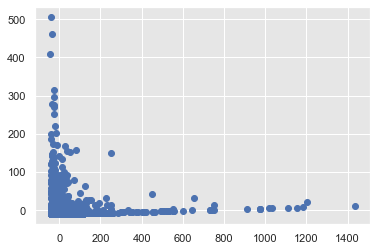

In [1183]:
from sklearn.decomposition import PCA
pca = PCA()
transformed = pca.fit_transform(X)
plt.scatter(transformed[:,0], transformed[:,1])

idx = transformed.argsort()[::-1]
eigenValues = transformed[idx]
eigenVectors = transformed[:,idx]

eigenValues

In [1187]:
first_two_comp = (idx[:,0], idx[:,1])
pcs = pd.DataFrame(first_two_comp).T
print(f'Variance of each component: {pca.explained_variance_ratio_}')
print(f'Total Variance Explained: {round(sum(list(pca.explained_variance_ratio_)))}')

Variance of each component: [9.18840442e-01 7.96358247e-02 7.73731571e-04 5.81675271e-05
 4.79243556e-05 3.58908299e-05 2.93470728e-05 2.64505016e-05
 2.56097084e-05 2.30804291e-05 2.21640000e-05 2.08525784e-05
 2.01743781e-05 1.92043323e-05 1.80520419e-05 1.66419002e-05
 1.64450569e-05 1.62006348e-05 1.56630453e-05 1.47721734e-05
 1.47332616e-05 1.40000194e-05 1.34447477e-05 1.32220235e-05
 1.24986922e-05 1.20070573e-05 1.19304665e-05 1.12547008e-05
 1.11332593e-05 1.09747245e-05 1.01042602e-05 9.78430214e-06
 9.61376382e-06 9.14013674e-06 9.00400299e-06 8.75187533e-06
 8.22100766e-06 8.15991967e-06 7.87759923e-06 7.23748522e-06
 7.13740959e-06 6.91117937e-06 6.65593547e-06 6.54388232e-06
 6.32554437e-06 6.21860944e-06 5.43131900e-06 5.38848475e-06
 5.23532695e-06 4.90997881e-06 4.72225967e-06 4.62527983e-06
 3.95925754e-06 3.58461521e-06 3.53771761e-06 3.29123812e-06
 3.28004744e-06 2.97534454e-06 2.87014553e-06 2.72367138e-06
 2.15997297e-06 1.66853161e-06 1.56699553e-06 1.40668573e

In [1191]:
sum(pca.explained_variance_ratio_[:1])

0.9188404417216481